# Ordering by metrics and retraining phase

## Dataset: GTSRB

## Experiment configuration 2
- Date: 27/10/2021

## Configuration
	2. Incremental guided retraining starting from the original model using the new adversarial inputs and original training set.

In [ ]:
pip install --user tensorflow==2.5

In [1]:
import tensorflow as tf

In [2]:
tf.__version__ == '2.5.0' # Version of tensorflow

True

In [1]:
import argparse

import numpy as np
import tensorflow as tf
import keras.backend as K

import matplotlib.pyplot as plt

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.regularizers import l2

import glob
import os
import cv2
import keras


import time
import argparse

from tqdm import tqdm

from keras.models import load_model, Model


In [2]:
# utils for project
import project_utils_v3_intel_dataset as utils

In [3]:
dataset = "gtsrb"

In [4]:
x_train,y_train = utils.get_data(dataset,"Train")
x_val,y_val = utils.get_data(dataset,"Val")
x_test,y_test = utils.get_data(dataset,"Test")

In [5]:
x_train_and_adversary,y_train_and_adversary = utils.get_data(dataset,"Train_and_adversary")

In [6]:
x_adversary_training = x_train_and_adversary[len(x_train):]
print(len(x_adversary_training))
y_adversary_training = y_train_and_adversary[len(y_train):]

print(len(y_adversary_training))

5000
5000


In [7]:
# Obtaining adversarial examples for testing 
x_test_and_adversary,y_test_and_adversary = utils.get_adversarial_data(dataset,'Test_fgsm') 

In [8]:
x_adversary_test_fgsm = x_test_and_adversary[len(x_test):]
print(len(x_adversary_test_fgsm))
y_adversary_test_fgsm = y_test_and_adversary[len(y_test):]

print(len(y_adversary_test_fgsm))

3923
3923


## ----

In [9]:
# Original model 
model_dir = "C:/Users/fjdur/Desktop/upc/project_notebooks/github_project/DL_notebooks/models/tf_model_25-06"


In [10]:
model_original = utils.My_model(dataset,True, model_dir)

Model loaded correctly


In [11]:
model_original.evaluate(x_test,y_test)

123/123 [==============================] - 17s 52ms/step - loss: 0.0293 - accuracy: 0.9929


[0.029302377253770828, 0.9928625822067261]

In [14]:
model_original.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm)

123/123 [==============================] - 6s 48ms/step - loss: 4.5121 - accuracy: 0.1843


[4.512054920196533, 0.18429772555828094]

## Obtaining new LSA and DSA values 

In [12]:
save_dir_lsa = "C:/Users/fjdur/Desktop/upc/project_notebooks/github_project/DL_notebooks/SA_values/lsa_values_1.npy"
 
save_dir_dsa = "C:/Users/fjdur/Desktop/upc/project_notebooks/github_project/DL_notebooks/SA_values/dsa_values_1.npy"

target_lsa = np.load(save_dir_lsa)
target_dsa = np.load(save_dir_dsa)

In [13]:
lsa_values = target_lsa
dsa_values = target_dsa

In [13]:

# Obtaining top n images by LSA values
top_images_by_lsa = utils.get_x_of_indexes(list(np.flip(np.argsort(lsa_values))),x_train_and_adversary)
top_labels_by_lsa = utils.get_x_of_indexes(list(np.flip(np.argsort(lsa_values))),y_train_and_adversary)


In [14]:

top_images_by_dsa = utils.get_x_of_indexes(list(np.flip(np.argsort(dsa_values))),x_train_and_adversary)
top_labels_by_dsa = utils.get_x_of_indexes(list(np.flip(np.argsort(dsa_values))),y_train_and_adversary)


In [17]:
len(top_images_by_lsa)//20

1818

In [54]:
len(x_train)

31366

In [60]:
top_images_by_lsa_5000 = np.array(top_images_by_lsa[:5000])
top_labels_by_lsa_5000 = np.array(top_labels_by_lsa[:5000])



In [18]:
m = 1800
n = 0
image_sets_lsa = []
label_sets_lsa = []


for i in range(len(top_images_by_lsa)//m):
    print(i,":")
    if (i+1 >= len(top_images_by_lsa)//m):
        print("Last")
        print(0," -> ",n+m+(len(top_images_by_lsa)%m))
        top_images_by_lsa_n = np.array(top_images_by_lsa[:n+m+(len(top_images_by_lsa)%m)])
        top_labels_by_lsa_n = np.array(top_labels_by_lsa[:n+m+(len(top_images_by_lsa)%m)])
    else:
        print(0," -> ",m+n)
        top_images_by_lsa_n = np.array(top_images_by_lsa[:n+m])
        top_labels_by_lsa_n = np.array(top_labels_by_lsa[:n+m])
    image_sets_lsa.append(top_images_by_lsa_n)
    label_sets_lsa.append(top_labels_by_lsa_n)
    print(len(top_images_by_lsa_n))
    n += m



0 :
0  ->  1800
1800
1 :
0  ->  3600
3600
2 :
0  ->  5400
5400
3 :
0  ->  7200
7200
4 :
0  ->  9000
9000
5 :
0  ->  10800
10800
6 :
0  ->  12600
12600
7 :
0  ->  14400
14400
8 :
0  ->  16200
16200
9 :
0  ->  18000
18000
10 :
0  ->  19800
19800
11 :
0  ->  21600
21600
12 :
0  ->  23400
23400
13 :
0  ->  25200
25200
14 :
0  ->  27000
27000
15 :
0  ->  28800
28800
16 :
0  ->  30600
30600
17 :
0  ->  32400
32400
18 :
0  ->  34200
34200
19 :
Last
0  ->  36366
36366


## point lsa

In [61]:
model_lsa_5000 =  utils.My_model(dataset,True,model_dir)
model_lsa_5000.compile_model()

Model loaded correctly
Model compiled


In [62]:
model_lsa_5000.fit_model(top_images_by_lsa_5000,top_labels_by_lsa_5000,x_val,y_val)

Epoch 1/10
79/79 [==============================] - 47s 491ms/step - loss: 2.2472 - accuracy: 0.4426 - val_loss: 0.2017 - val_accuracy: 0.9663
Epoch 2/10
79/79 [==============================] - 38s 484ms/step - loss: 1.1129 - accuracy: 0.6862 - val_loss: 0.4781 - val_accuracy: 0.8928
Epoch 3/10
79/79 [==============================] - 39s 492ms/step - loss: 0.7918 - accuracy: 0.7596 - val_loss: 0.8992 - val_accuracy: 0.8283
Epoch 4/10
79/79 [==============================] - 39s 490ms/step - loss: 0.6117 - accuracy: 0.8270 - val_loss: 0.5346 - val_accuracy: 0.8523
Epoch 5/10
79/79 [==============================] - 38s 487ms/step - loss: 0.4824 - accuracy: 0.8526 - val_loss: 1.3374 - val_accuracy: 0.8160
Epoch 6/10
79/79 [==============================] - 38s 482ms/step - loss: 0.4202 - accuracy: 0.8749 - val_loss: 2.0235 - val_accuracy: 0.7367
Epoch 7/10
79/79 [==============================] - 38s 486ms/step - loss: 0.3859 - accuracy: 0.8850 - val_loss: 1.4919 - val_accuracy: 0.8102

In [28]:
print(model_dir)

models_lsa = []
for i in range(len(label_sets_lsa)):
    print(i,":")
    model = utils.My_model(dataset,True,model_dir)
    model.compile_model()
    models_lsa.append(model)


C:/Users/fjdur/Desktop/upc/project_notebooks/github_project/DL_notebooks/models/tf_model_25-06
0 :
Model loaded correctly
Model compiled
1 :
Model loaded correctly
Model compiled
2 :
Model loaded correctly
Model compiled
3 :
Model loaded correctly
Model compiled
4 :
Model loaded correctly
Model compiled
5 :
Model loaded correctly
Model compiled
6 :
Model loaded correctly
Model compiled
7 :
Model loaded correctly
Model compiled
8 :
Model loaded correctly
Model compiled
9 :
Model loaded correctly
Model compiled
10 :
Model loaded correctly
Model compiled
11 :
Model loaded correctly
Model compiled
12 :
Model loaded correctly
Model compiled
13 :
Model loaded correctly
Model compiled
14 :
Model loaded correctly
Model compiled
15 :
Model loaded correctly
Model compiled
16 :
Model loaded correctly
Model compiled
17 :
Model loaded correctly
Model compiled
18 :
Model loaded correctly
Model compiled
19 :
Model loaded correctly
Model compiled


In [29]:
n = 0
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n=n+1

Epoch 1/10
29/29 [==============================] - 21s 676ms/step - loss: 3.5568 - accuracy: 0.1698 - val_loss: 0.5954 - val_accuracy: 0.8627
Epoch 2/10
29/29 [==============================] - 19s 658ms/step - loss: 2.1412 - accuracy: 0.4189 - val_loss: 0.3260 - val_accuracy: 0.9053
Epoch 3/10
29/29 [==============================] - 19s 658ms/step - loss: 1.6907 - accuracy: 0.5140 - val_loss: 1.0183 - val_accuracy: 0.8015
Epoch 4/10
29/29 [==============================] - 19s 660ms/step - loss: 1.3568 - accuracy: 0.5942 - val_loss: 0.3570 - val_accuracy: 0.9028
Epoch 5/10
29/29 [==============================] - 19s 661ms/step - loss: 1.0867 - accuracy: 0.6889 - val_loss: 0.4366 - val_accuracy: 0.8969
Epoch 6/10
29/29 [==============================] - 19s 654ms/step - loss: 0.9439 - accuracy: 0.7312 - val_loss: 0.5996 - val_accuracy: 0.8443
Epoch 7/10
29/29 [==============================] - 19s 651ms/step - loss: 0.8805 - accuracy: 0.7291 - val_loss: 1.0838 - val_accuracy: 0.8193

In [30]:
n=1
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

Epoch 1/10
57/57 [==============================] - 33s 554ms/step - loss: 3.0463 - accuracy: 0.2587 - val_loss: 0.4009 - val_accuracy: 0.8910
Epoch 2/10
57/57 [==============================] - 32s 567ms/step - loss: 1.4831 - accuracy: 0.5797 - val_loss: 0.4052 - val_accuracy: 0.8977
Epoch 3/10
57/57 [==============================] - 33s 574ms/step - loss: 1.1765 - accuracy: 0.6553 - val_loss: 0.7222 - val_accuracy: 0.8089
Epoch 4/10
57/57 [==============================] - 31s 543ms/step - loss: 0.8822 - accuracy: 0.7357 - val_loss: 0.6737 - val_accuracy: 0.8221
Epoch 5/10
57/57 [==============================] - 30s 530ms/step - loss: 0.7210 - accuracy: 0.7913 - val_loss: 0.7349 - val_accuracy: 0.7900
Epoch 6/10
57/57 [==============================] - 30s 528ms/step - loss: 0.6416 - accuracy: 0.8020 - val_loss: 0.5039 - val_accuracy: 0.8617
Epoch 7/10
57/57 [==============================] - 30s 528ms/step - loss: 0.6073 - accuracy: 0.8314 - val_loss: 1.1844 - val_accuracy: 0.8035

In [31]:
print(n)
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

2
Epoch 1/10
85/85 [==============================] - 46s 515ms/step - loss: 2.2295 - accuracy: 0.4468 - val_loss: 0.3609 - val_accuracy: 0.9153
Epoch 2/10
85/85 [==============================] - 43s 508ms/step - loss: 1.0812 - accuracy: 0.6949 - val_loss: 0.2688 - val_accuracy: 0.9288
Epoch 3/10
85/85 [==============================] - 44s 518ms/step - loss: 0.7992 - accuracy: 0.7650 - val_loss: 0.5313 - val_accuracy: 0.8775
Epoch 4/10
85/85 [==============================] - 44s 513ms/step - loss: 0.6411 - accuracy: 0.8190 - val_loss: 0.4868 - val_accuracy: 0.8722
Epoch 5/10
85/85 [==============================] - 44s 513ms/step - loss: 0.4877 - accuracy: 0.8532 - val_loss: 0.7753 - val_accuracy: 0.8265
Epoch 6/10
85/85 [==============================] - 44s 514ms/step - loss: 0.4622 - accuracy: 0.8604 - val_loss: 1.8562 - val_accuracy: 0.7780
Epoch 7/10
85/85 [==============================] - 44s 516ms/step - loss: 0.3765 - accuracy: 0.8879 - val_loss: 0.6904 - val_accuracy: 0.85

In [32]:
print(n)
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

3
Epoch 1/10
113/113 [==============================] - 59s 510ms/step - loss: 1.6453 - accuracy: 0.5839 - val_loss: 0.1348 - val_accuracy: 0.9699
Epoch 2/10
113/113 [==============================] - 57s 508ms/step - loss: 0.8030 - accuracy: 0.7719 - val_loss: 0.1986 - val_accuracy: 0.9548
Epoch 3/10
113/113 [==============================] - 58s 515ms/step - loss: 0.5901 - accuracy: 0.8294 - val_loss: 0.1715 - val_accuracy: 0.9518
Epoch 4/10
113/113 [==============================] - 58s 513ms/step - loss: 0.4935 - accuracy: 0.8544 - val_loss: 0.2691 - val_accuracy: 0.9273
Epoch 5/10
113/113 [==============================] - 58s 514ms/step - loss: 0.4142 - accuracy: 0.8835 - val_loss: 0.4807 - val_accuracy: 0.9122
Epoch 6/10
113/113 [==============================] - 58s 512ms/step - loss: 0.3625 - accuracy: 0.8946 - val_loss: 0.2820 - val_accuracy: 0.9237
Epoch 7/10
113/113 [==============================] - 58s 512ms/step - loss: 0.2857 - accuracy: 0.9171 - val_loss: 0.1900 - val_

In [33]:
print(n) #4
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

4
Epoch 1/10
141/141 [==============================] - 73s 503ms/step - loss: 1.3332 - accuracy: 0.6675 - val_loss: 0.1793 - val_accuracy: 0.9666
Epoch 2/10
141/141 [==============================] - 71s 501ms/step - loss: 0.6628 - accuracy: 0.8137 - val_loss: 0.2103 - val_accuracy: 0.9462
Epoch 3/10
141/141 [==============================] - 71s 506ms/step - loss: 0.4801 - accuracy: 0.8593 - val_loss: 0.2458 - val_accuracy: 0.9283
Epoch 4/10
141/141 [==============================] - 72s 512ms/step - loss: 0.3626 - accuracy: 0.8926 - val_loss: 0.1883 - val_accuracy: 0.9482
Epoch 5/10
141/141 [==============================] - 72s 509ms/step - loss: 0.3221 - accuracy: 0.9074 - val_loss: 0.2245 - val_accuracy: 0.9357
Epoch 6/10
141/141 [==============================] - 72s 510ms/step - loss: 0.2752 - accuracy: 0.9183 - val_loss: 0.1446 - val_accuracy: 0.9587
Epoch 7/10
141/141 [==============================] - 72s 511ms/step - loss: 0.2216 - accuracy: 0.9359 - val_loss: 0.2169 - val_

In [34]:
print(n)
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

5
Epoch 1/10
169/169 [==============================] - 87s 505ms/step - loss: 1.1797 - accuracy: 0.7030 - val_loss: 0.0895 - val_accuracy: 0.9773
Epoch 2/10
169/169 [==============================] - 85s 502ms/step - loss: 0.6088 - accuracy: 0.8289 - val_loss: 0.1042 - val_accuracy: 0.9735
Epoch 3/10
169/169 [==============================] - 85s 501ms/step - loss: 0.4193 - accuracy: 0.8840 - val_loss: 0.1507 - val_accuracy: 0.9551
Epoch 4/10
169/169 [==============================] - 84s 500ms/step - loss: 0.3480 - accuracy: 0.9028 - val_loss: 0.1006 - val_accuracy: 0.9727
Epoch 5/10
169/169 [==============================] - 85s 500ms/step - loss: 0.2928 - accuracy: 0.9169 - val_loss: 0.1006 - val_accuracy: 0.9735
Epoch 6/10
169/169 [==============================] - 84s 496ms/step - loss: 0.2636 - accuracy: 0.9229 - val_loss: 0.1220 - val_accuracy: 0.9686
Epoch 7/10
169/169 [==============================] - 85s 504ms/step - loss: 0.2370 - accuracy: 0.9347 - val_loss: 0.1676 - val_

In [35]:
print(n)
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

6
Epoch 1/10
197/197 [==============================] - 101s 502ms/step - loss: 1.0187 - accuracy: 0.7451 - val_loss: 0.1031 - val_accuracy: 0.9666
Epoch 2/10
197/197 [==============================] - 99s 501ms/step - loss: 0.4820 - accuracy: 0.8627 - val_loss: 0.1095 - val_accuracy: 0.9668
Epoch 3/10
197/197 [==============================] - 99s 504ms/step - loss: 0.3835 - accuracy: 0.8898 - val_loss: 0.1372 - val_accuracy: 0.9661
Epoch 4/10
197/197 [==============================] - 99s 503ms/step - loss: 0.2974 - accuracy: 0.9177 - val_loss: 0.0909 - val_accuracy: 0.9704
Epoch 5/10
197/197 [==============================] - 99s 504ms/step - loss: 0.2653 - accuracy: 0.9264 - val_loss: 0.0858 - val_accuracy: 0.9752
Epoch 6/10
197/197 [==============================] - 99s 504ms/step - loss: 0.2237 - accuracy: 0.9394 - val_loss: 0.0845 - val_accuracy: 0.9781
Epoch 7/10
197/197 [==============================] - 99s 500ms/step - loss: 0.2063 - accuracy: 0.9434 - val_loss: 0.0829 - val

In [36]:
print(n)
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

7
Epoch 1/10
225/225 [==============================] - 496s 2s/step - loss: 0.8653 - accuracy: 0.7819 - val_loss: 0.0653 - val_accuracy: 0.9852
Epoch 2/10
225/225 [==============================] - 111s 494ms/step - loss: 0.4409 - accuracy: 0.8723 - val_loss: 0.0633 - val_accuracy: 0.9849
Epoch 3/10
225/225 [==============================] - 110s 489ms/step - loss: 0.3301 - accuracy: 0.9081 - val_loss: 0.0730 - val_accuracy: 0.9768
Epoch 4/10
225/225 [==============================] - 111s 491ms/step - loss: 0.2577 - accuracy: 0.9247 - val_loss: 0.0864 - val_accuracy: 0.9760
Epoch 5/10
225/225 [==============================] - 110s 490ms/step - loss: 0.2340 - accuracy: 0.9326 - val_loss: 0.0749 - val_accuracy: 0.9842
Epoch 6/10
225/225 [==============================] - 110s 491ms/step - loss: 0.2252 - accuracy: 0.9419 - val_loss: 0.1581 - val_accuracy: 0.9576
Epoch 7/10
225/225 [==============================] - 114s 505ms/step - loss: 0.1943 - accuracy: 0.9479 - val_loss: 0.0697 - 

In [37]:
print(n)
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

8
Epoch 1/10
254/254 [==============================] - 127s 493ms/step - loss: 0.8114 - accuracy: 0.7935 - val_loss: 0.1353 - val_accuracy: 0.9610
Epoch 2/10
254/254 [==============================] - 124s 486ms/step - loss: 0.4251 - accuracy: 0.8810 - val_loss: 0.0867 - val_accuracy: 0.9798
Epoch 3/10
254/254 [==============================] - 124s 487ms/step - loss: 0.3155 - accuracy: 0.9109 - val_loss: 0.0732 - val_accuracy: 0.9788
Epoch 4/10
254/254 [==============================] - 124s 488ms/step - loss: 0.2662 - accuracy: 0.9254 - val_loss: 0.0593 - val_accuracy: 0.9816
Epoch 5/10
254/254 [==============================] - 124s 488ms/step - loss: 0.2352 - accuracy: 0.9360 - val_loss: 0.0925 - val_accuracy: 0.9765
Epoch 6/10
254/254 [==============================] - 123s 483ms/step - loss: 0.1937 - accuracy: 0.9461 - val_loss: 0.2138 - val_accuracy: 0.9250
Epoch 7/10
254/254 [==============================] - 123s 483ms/step - loss: 0.1920 - accuracy: 0.9476 - val_loss: 0.1384

In [38]:
print(n)#9
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

9
Epoch 1/10
282/282 [==============================] - 144s 504ms/step - loss: 0.7174 - accuracy: 0.8194 - val_loss: 0.0398 - val_accuracy: 0.9898
Epoch 2/10
282/282 [==============================] - 135s 480ms/step - loss: 0.3986 - accuracy: 0.8869 - val_loss: 0.0845 - val_accuracy: 0.9760
Epoch 3/10
282/282 [==============================] - 136s 483ms/step - loss: 0.2939 - accuracy: 0.9162 - val_loss: 0.0899 - val_accuracy: 0.9783
Epoch 4/10
282/282 [==============================] - 136s 483ms/step - loss: 0.2686 - accuracy: 0.9272 - val_loss: 0.0704 - val_accuracy: 0.9798
Epoch 5/10
282/282 [==============================] - 137s 485ms/step - loss: 0.2058 - accuracy: 0.9447 - val_loss: 0.0735 - val_accuracy: 0.9804
Epoch 6/10
282/282 [==============================] - 136s 482ms/step - loss: 0.2005 - accuracy: 0.9435 - val_loss: 0.2019 - val_accuracy: 0.9508
Epoch 7/10
282/282 [==============================] - 136s 481ms/step - loss: 0.1888 - accuracy: 0.9501 - val_loss: 0.0942

In [39]:
print(n)
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

10
Epoch 1/10
310/310 [==============================] - 154s 489ms/step - loss: 0.6722 - accuracy: 0.8325 - val_loss: 0.0475 - val_accuracy: 0.9898
Epoch 2/10
310/310 [==============================] - 150s 483ms/step - loss: 0.3486 - accuracy: 0.9021 - val_loss: 0.0770 - val_accuracy: 0.9824
Epoch 3/10
310/310 [==============================] - 150s 485ms/step - loss: 0.2623 - accuracy: 0.9228 - val_loss: 0.0687 - val_accuracy: 0.9814
Epoch 4/10
310/310 [==============================] - 149s 482ms/step - loss: 0.2396 - accuracy: 0.9339 - val_loss: 0.0742 - val_accuracy: 0.9778
Epoch 5/10
310/310 [==============================] - 150s 483ms/step - loss: 0.2102 - accuracy: 0.9434 - val_loss: 0.0748 - val_accuracy: 0.9778
Epoch 6/10
310/310 [==============================] - 150s 484ms/step - loss: 0.1911 - accuracy: 0.9480 - val_loss: 0.1444 - val_accuracy: 0.9528
Epoch 7/10
310/310 [==============================] - 149s 482ms/step - loss: 0.1787 - accuracy: 0.9532 - val_loss: 0.097

In [40]:
print(n)
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

11
Epoch 1/10
338/338 [==============================] - 161s 470ms/step - loss: 0.6047 - accuracy: 0.8449 - val_loss: 0.0576 - val_accuracy: 0.9834
Epoch 2/10
338/338 [==============================] - 160s 474ms/step - loss: 0.3501 - accuracy: 0.9014 - val_loss: 0.1401 - val_accuracy: 0.9668
Epoch 3/10
338/338 [==============================] - 161s 476ms/step - loss: 0.2652 - accuracy: 0.9257 - val_loss: 0.0753 - val_accuracy: 0.9773
Epoch 4/10
338/338 [==============================] - 161s 476ms/step - loss: 0.2286 - accuracy: 0.9368 - val_loss: 0.1045 - val_accuracy: 0.9696
Epoch 5/10
338/338 [==============================] - 161s 475ms/step - loss: 0.2166 - accuracy: 0.9439 - val_loss: 0.1092 - val_accuracy: 0.9770
Epoch 6/10
338/338 [==============================] - 161s 476ms/step - loss: 0.1948 - accuracy: 0.9473 - val_loss: 0.1122 - val_accuracy: 0.9668
Epoch 7/10
338/338 [==============================] - 162s 478ms/step - loss: 0.1843 - accuracy: 0.9520 - val_loss: 0.093

In [41]:
print(n)
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

12
Epoch 1/10
366/366 [==============================] - 177s 477ms/step - loss: 0.5741 - accuracy: 0.8570 - val_loss: 0.0548 - val_accuracy: 0.9857
Epoch 2/10
366/366 [==============================] - 172s 471ms/step - loss: 0.3190 - accuracy: 0.9082 - val_loss: 0.1368 - val_accuracy: 0.9604
Epoch 3/10
366/366 [==============================] - 173s 472ms/step - loss: 0.2484 - accuracy: 0.9329 - val_loss: 0.1008 - val_accuracy: 0.9750
Epoch 4/10
366/366 [==============================] - 172s 470ms/step - loss: 0.2214 - accuracy: 0.9404 - val_loss: 0.0562 - val_accuracy: 0.9837
Epoch 5/10
366/366 [==============================] - 173s 472ms/step - loss: 0.2034 - accuracy: 0.9460 - val_loss: 0.1100 - val_accuracy: 0.9714
Epoch 6/10
366/366 [==============================] - 173s 471ms/step - loss: 0.1821 - accuracy: 0.9524 - val_loss: 0.0818 - val_accuracy: 0.9770
Epoch 7/10
366/366 [==============================] - 172s 470ms/step - loss: 0.1644 - accuracy: 0.9558 - val_loss: 0.099

In [42]:
print(n)
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

13
Epoch 1/10
394/394 [==============================] - 185s 465ms/step - loss: 0.5396 - accuracy: 0.8671 - val_loss: 0.0787 - val_accuracy: 0.9768
Epoch 2/10
394/394 [==============================] - 183s 465ms/step - loss: 0.3015 - accuracy: 0.9170 - val_loss: 0.0782 - val_accuracy: 0.9760
Epoch 3/10
394/394 [==============================] - 183s 465ms/step - loss: 0.2457 - accuracy: 0.9295 - val_loss: 0.1219 - val_accuracy: 0.9694
Epoch 4/10
394/394 [==============================] - 182s 463ms/step - loss: 0.2109 - accuracy: 0.9422 - val_loss: 0.0973 - val_accuracy: 0.9735
Epoch 5/10
394/394 [==============================] - 182s 462ms/step - loss: 0.1777 - accuracy: 0.9508 - val_loss: 0.1104 - val_accuracy: 0.9719
Epoch 6/10
394/394 [==============================] - 181s 460ms/step - loss: 0.1944 - accuracy: 0.9460 - val_loss: 0.1592 - val_accuracy: 0.9686
Epoch 7/10
394/394 [==============================] - 181s 460ms/step - loss: 0.1699 - accuracy: 0.9582 - val_loss: 0.115

In [43]:
print(n)#14
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

14
Epoch 1/10
422/422 [==============================] - 208s 489ms/step - loss: 0.4993 - accuracy: 0.8745 - val_loss: 0.1045 - val_accuracy: 0.9860
Epoch 2/10
422/422 [==============================] - 387s 917ms/step - loss: 0.2798 - accuracy: 0.9236 - val_loss: 0.0971 - val_accuracy: 0.9806
Epoch 3/10
422/422 [==============================] - 199s 471ms/step - loss: 0.2259 - accuracy: 0.9373 - val_loss: 0.0910 - val_accuracy: 0.9775
Epoch 4/10
422/422 [==============================] - 198s 469ms/step - loss: 0.1959 - accuracy: 0.9468 - val_loss: 0.0758 - val_accuracy: 0.9814
Epoch 5/10
422/422 [==============================] - 29276s 70s/step - loss: 0.1790 - accuracy: 0.9508 - val_loss: 0.1403 - val_accuracy: 0.9622
Epoch 6/10
422/422 [==============================] - 218s 517ms/step - loss: 0.1697 - accuracy: 0.9561 - val_loss: 0.1079 - val_accuracy: 0.9737
Epoch 7/10
422/422 [==============================] - 217s 514ms/step - loss: 0.1692 - accuracy: 0.9581 - val_loss: 0.125

In [44]:
print(n)
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

15
Epoch 1/10
450/450 [==============================] - 226s 497ms/step - loss: 0.4693 - accuracy: 0.8821 - val_loss: 0.0762 - val_accuracy: 0.9834
Epoch 2/10
450/450 [==============================] - 217s 483ms/step - loss: 0.2756 - accuracy: 0.9245 - val_loss: 0.0486 - val_accuracy: 0.9872
Epoch 3/10
450/450 [==============================] - 220s 490ms/step - loss: 0.1988 - accuracy: 0.9423 - val_loss: 0.0836 - val_accuracy: 0.9806
Epoch 4/10
450/450 [==============================] - 222s 493ms/step - loss: 0.1993 - accuracy: 0.9441 - val_loss: 0.1067 - val_accuracy: 0.9712
Epoch 5/10
450/450 [==============================] - 218s 485ms/step - loss: 0.1755 - accuracy: 0.9540 - val_loss: 0.0952 - val_accuracy: 0.9727
Epoch 6/10
450/450 [==============================] - 219s 487ms/step - loss: 0.1619 - accuracy: 0.9564 - val_loss: 0.0807 - val_accuracy: 0.9796
Epoch 7/10
450/450 [==============================] - 206s 458ms/step - loss: 0.1732 - accuracy: 0.9578 - val_loss: 0.094

In [45]:
print(n)
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

16
Epoch 1/10
479/479 [==============================] - 213s 440ms/step - loss: 0.4663 - accuracy: 0.8845 - val_loss: 0.0611 - val_accuracy: 0.9844
Epoch 2/10
479/479 [==============================] - 211s 440ms/step - loss: 0.2566 - accuracy: 0.9287 - val_loss: 0.2524 - val_accuracy: 0.9515
Epoch 3/10
479/479 [==============================] - 210s 439ms/step - loss: 0.2234 - accuracy: 0.9381 - val_loss: 0.0522 - val_accuracy: 0.9847
Epoch 4/10
479/479 [==============================] - 211s 440ms/step - loss: 0.1952 - accuracy: 0.9447 - val_loss: 0.0848 - val_accuracy: 0.9793
Epoch 5/10
479/479 [==============================] - 211s 441ms/step - loss: 0.1686 - accuracy: 0.9549 - val_loss: 0.1039 - val_accuracy: 0.9707
Epoch 6/10
479/479 [==============================] - 211s 440ms/step - loss: 0.1669 - accuracy: 0.9533 - val_loss: 0.0706 - val_accuracy: 0.9786
Epoch 7/10
479/479 [==============================] - 211s 440ms/step - loss: 0.1701 - accuracy: 0.9593 - val_loss: 0.261

In [46]:
print(n)
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

17
Epoch 1/10
507/507 [==============================] - 225s 441ms/step - loss: 0.4209 - accuracy: 0.8953 - val_loss: 0.0661 - val_accuracy: 0.9832
Epoch 2/10
507/507 [==============================] - 223s 441ms/step - loss: 0.2482 - accuracy: 0.9318 - val_loss: 0.0703 - val_accuracy: 0.9819
Epoch 3/10
507/507 [==============================] - 224s 442ms/step - loss: 0.2207 - accuracy: 0.9395 - val_loss: 0.0738 - val_accuracy: 0.9824
Epoch 4/10
507/507 [==============================] - 224s 442ms/step - loss: 0.1871 - accuracy: 0.9488 - val_loss: 0.0941 - val_accuracy: 0.9768
Epoch 5/10
507/507 [==============================] - 224s 441ms/step - loss: 0.1790 - accuracy: 0.9509 - val_loss: 0.0926 - val_accuracy: 0.9727
Epoch 6/10
507/507 [==============================] - 223s 440ms/step - loss: 0.1667 - accuracy: 0.9574 - val_loss: 0.0664 - val_accuracy: 0.9816
Epoch 7/10
507/507 [==============================] - 224s 442ms/step - loss: 0.1646 - accuracy: 0.9600 - val_loss: 0.114

In [47]:
print(n)
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

18
Epoch 1/10
535/535 [==============================] - 243s 450ms/step - loss: 0.4096 - accuracy: 0.8969 - val_loss: 0.0314 - val_accuracy: 0.9923
Epoch 2/10
535/535 [==============================] - 233s 436ms/step - loss: 0.2436 - accuracy: 0.9311 - val_loss: 0.0288 - val_accuracy: 0.9941
Epoch 3/10
535/535 [==============================] - 234s 437ms/step - loss: 0.2150 - accuracy: 0.9415 - val_loss: 0.0350 - val_accuracy: 0.9934
Epoch 4/10
535/535 [==============================] - 234s 437ms/step - loss: 0.1790 - accuracy: 0.9520 - val_loss: 0.0371 - val_accuracy: 0.9906
Epoch 5/10
535/535 [==============================] - 235s 439ms/step - loss: 0.1798 - accuracy: 0.9527 - val_loss: 0.0535 - val_accuracy: 0.9895
Epoch 6/10
535/535 [==============================] - 234s 438ms/step - loss: 0.1715 - accuracy: 0.9560 - val_loss: 0.0309 - val_accuracy: 0.9918
Epoch 7/10
535/535 [==============================] - 234s 438ms/step - loss: 0.1629 - accuracy: 0.9593 - val_loss: 0.058

In [48]:
print(n)#19
models_lsa[n].fit_model(image_sets_lsa[n],label_sets_lsa[n],x_val,y_val)
n = n+1

19
Epoch 1/10
569/569 [==============================] - 253s 441ms/step - loss: 0.4039 - accuracy: 0.8993 - val_loss: 0.0355 - val_accuracy: 0.9911
Epoch 2/10
569/569 [==============================] - 250s 440ms/step - loss: 0.2462 - accuracy: 0.9348 - val_loss: 0.0368 - val_accuracy: 0.9895
Epoch 3/10
569/569 [==============================] - 251s 441ms/step - loss: 0.2017 - accuracy: 0.9451 - val_loss: 0.0328 - val_accuracy: 0.9921
Epoch 4/10
569/569 [==============================] - 251s 441ms/step - loss: 0.1859 - accuracy: 0.9498 - val_loss: 0.0303 - val_accuracy: 0.9954
Epoch 5/10
569/569 [==============================] - 251s 441ms/step - loss: 0.1838 - accuracy: 0.9518 - val_loss: 0.0420 - val_accuracy: 0.9939
Epoch 6/10
569/569 [==============================] - 251s 442ms/step - loss: 0.1707 - accuracy: 0.9567 - val_loss: 0.0183 - val_accuracy: 0.9949
Epoch 7/10
569/569 [==============================] - 252s 443ms/step - loss: 0.1803 - accuracy: 0.9553 - val_loss: 0.025

In [16]:
loading = True

models_lsa = []

if loading:
    for i in range(20):
        model_lsa_dir = "D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_lsa_e2_"+str(i)
        print(model_lsa_dir)
        model =utils.My_model('gtsrb',True,model_lsa_dir)
        model.model.compile(loss= 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        models_lsa.append(model)

D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_lsa_e2_0
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_lsa_e2_1
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_lsa_e2_2
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_lsa_e2_3
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_lsa_e2_4
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_lsa_e2_5
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_lsa_e2_6
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_lsa_e2_7
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_lsa_e2_8
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_lsa_e2_9
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_lsa_e2_10
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_lsa_e2_11
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_lsa_e2_12
Model loaded correc

In [29]:

        
model_lsa_dir_5000 = "D:/models/gtsrb/C3/gtsrb_model_c3_sep_lsa_e2_5000"
model_lsa_5000 =utils.My_model('gtsrb',True,model_lsa_dir_5000)
model_lsa_5000.model.compile(loss= 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


Model loaded correctly


## DSA

## Point dsa

In [15]:
top_images_by_dsa_5000 = np.array(top_images_by_dsa[:5000])
top_labels_by_dsa_5000 = np.array(top_labels_by_dsa[:5000])


In [16]:
model_dsa_5000 =  utils.My_model(dataset,True,model_dir)
model_dsa_5000.compile_model()

Model loaded correctly
Model compiled


In [17]:
model_dsa_5000.fit_model(top_images_by_dsa_5000,top_labels_by_dsa_5000,x_val,y_val)

Epoch 1/10
79/79 [==============================] - 55s 484ms/step - loss: 2.5676 - accuracy: 0.3474 - val_loss: 0.5547 - val_accuracy: 0.8625
Epoch 2/10
79/79 [==============================] - 38s 482ms/step - loss: 1.2156 - accuracy: 0.6544 - val_loss: 0.5245 - val_accuracy: 0.8591
Epoch 3/10
79/79 [==============================] - 40s 512ms/step - loss: 0.9192 - accuracy: 0.7364 - val_loss: 0.5093 - val_accuracy: 0.8671
Epoch 4/10
79/79 [==============================] - 43s 548ms/step - loss: 0.7300 - accuracy: 0.7850 - val_loss: 0.9045 - val_accuracy: 0.7772
Epoch 5/10
79/79 [==============================] - 41s 514ms/step - loss: 0.5861 - accuracy: 0.8334 - val_loss: 0.5801 - val_accuracy: 0.8528
Epoch 6/10
79/79 [==============================] - 41s 521ms/step - loss: 0.4953 - accuracy: 0.8552 - val_loss: 0.4364 - val_accuracy: 0.8936
Epoch 7/10
79/79 [==============================] - 39s 490ms/step - loss: 0.4303 - accuracy: 0.8715 - val_loss: 0.8012 - val_accuracy: 0.7956

In [17]:
m = 1800
n = 0
image_sets_dsa = []
label_sets_dsa = []


for i in range(len(top_images_by_dsa)//m):
    print(i,":")
    if (i+1 >= len(top_images_by_dsa)//m):
        print("Last")
        print(0," -> ",n+m+(len(top_images_by_dsa)%m))
        top_images_by_dsa_n = np.array(top_images_by_dsa[:n+m+(len(top_images_by_dsa)%m)])
        top_labels_by_dsa_n = np.array(top_labels_by_dsa[:n+m+(len(top_images_by_dsa)%m)])
    else:
        print(0," -> ",m+n)
        top_images_by_dsa_n = np.array(top_images_by_dsa[:n+m])
        top_labels_by_dsa_n = np.array(top_labels_by_dsa[:n+m])
    image_sets_dsa.append(top_images_by_dsa_n)
    label_sets_dsa.append(top_labels_by_dsa_n)
    print(len(top_images_by_dsa_n))
    n += m



0 :
0  ->  1800
1800
1 :
0  ->  3600
3600
2 :
0  ->  5400
5400
3 :
0  ->  7200
7200
4 :
0  ->  9000
9000
5 :
0  ->  10800
10800
6 :
0  ->  12600
12600
7 :
0  ->  14400
14400
8 :
0  ->  16200
16200
9 :
0  ->  18000
18000
10 :
0  ->  19800
19800
11 :
0  ->  21600
21600
12 :
0  ->  23400
23400
13 :
0  ->  25200
25200
14 :
0  ->  27000
27000
15 :
0  ->  28800
28800
16 :
0  ->  30600
30600
17 :
0  ->  32400
32400
18 :
0  ->  34200
34200
19 :
Last
0  ->  36366
36366


In [20]:
print(model_dir)

models_dsa = []
for i in range(len(label_sets_dsa)):
    print(i,":")
    model = utils.My_model('gtsrb',True,model_dir)
    model.compile_model()
    models_dsa.append(model)


C:/Users/fjdur/Desktop/upc/project_notebooks/github_project/DL_notebooks/models/tf_model_25-06
0 :
Model loaded correctly
Model compiled
1 :
Model loaded correctly
Model compiled
2 :
Model loaded correctly
Model compiled
3 :
Model loaded correctly
Model compiled
4 :
Model loaded correctly
Model compiled
5 :
Model loaded correctly
Model compiled
6 :
Model loaded correctly
Model compiled
7 :
Model loaded correctly
Model compiled
8 :
Model loaded correctly
Model compiled
9 :
Model loaded correctly
Model compiled
10 :
Model loaded correctly
Model compiled
11 :
Model loaded correctly
Model compiled
12 :
Model loaded correctly
Model compiled
13 :
Model loaded correctly
Model compiled
14 :
Model loaded correctly
Model compiled
15 :
Model loaded correctly
Model compiled
16 :
Model loaded correctly
Model compiled
17 :
Model loaded correctly
Model compiled
18 :
Model loaded correctly
Model compiled
19 :
Model loaded correctly
Model compiled


In [56]:
models_dsa[1].evaluate(x_test,y_test)

123/123 [==============================] - 8s 59ms/step - loss: 0.0595 - accuracy: 0.9859


[0.029302377253770828, 0.9928625822067261]

In [55]:
n=0

In [31]:
n=0
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

0
Epoch 1/10
29/29 [==============================] - 20s 623ms/step - loss: 3.5564 - accuracy: 0.1722 - val_loss: 0.3946 - val_accuracy: 0.9076
Epoch 2/10
29/29 [==============================] - 17s 604ms/step - loss: 1.9154 - accuracy: 0.4793 - val_loss: 0.9690 - val_accuracy: 0.8334
Epoch 3/10
29/29 [==============================] - 17s 608ms/step - loss: 1.5983 - accuracy: 0.5643 - val_loss: 1.0980 - val_accuracy: 0.8178
Epoch 4/10
29/29 [==============================] - 17s 605ms/step - loss: 1.2754 - accuracy: 0.6391 - val_loss: 0.3896 - val_accuracy: 0.8918
Epoch 5/10
29/29 [==============================] - 17s 607ms/step - loss: 1.0439 - accuracy: 0.6838 - val_loss: 0.5365 - val_accuracy: 0.8569
Epoch 6/10
29/29 [==============================] - 17s 607ms/step - loss: 0.9646 - accuracy: 0.7252 - val_loss: 0.5419 - val_accuracy: 0.8591
Epoch 7/10
29/29 [==============================] - 18s 620ms/step - loss: 0.8457 - accuracy: 0.7419 - val_loss: 1.6124 - val_accuracy: 0.64

In [21]:
n=1
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

1
Epoch 1/10
57/57 [==============================] - 30s 501ms/step - loss: 2.8749 - accuracy: 0.2735 - val_loss: 0.4392 - val_accuracy: 0.8813
Epoch 2/10
57/57 [==============================] - 28s 492ms/step - loss: 1.4353 - accuracy: 0.6021 - val_loss: 0.4914 - val_accuracy: 0.8877
Epoch 3/10
57/57 [==============================] - 28s 484ms/step - loss: 1.0745 - accuracy: 0.6916 - val_loss: 0.4412 - val_accuracy: 0.8842
Epoch 4/10
57/57 [==============================] - 28s 489ms/step - loss: 0.8491 - accuracy: 0.7452 - val_loss: 0.5784 - val_accuracy: 0.8459
Epoch 5/10
57/57 [==============================] - 28s 487ms/step - loss: 0.6655 - accuracy: 0.7993 - val_loss: 0.6309 - val_accuracy: 0.8369
Epoch 6/10
57/57 [==============================] - 28s 488ms/step - loss: 0.6135 - accuracy: 0.8115 - val_loss: 1.5231 - val_accuracy: 0.8122
Epoch 7/10
57/57 [==============================] - 29s 510ms/step - loss: 0.5206 - accuracy: 0.8474 - val_loss: 0.4761 - val_accuracy: 0.87

In [22]:
n=2
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

2
Epoch 1/10
85/85 [==============================] - 41s 460ms/step - loss: 2.4935 - accuracy: 0.3923 - val_loss: 0.4134 - val_accuracy: 0.8936
Epoch 2/10
85/85 [==============================] - 38s 453ms/step - loss: 1.1246 - accuracy: 0.6840 - val_loss: 1.1303 - val_accuracy: 0.8390
Epoch 3/10
85/85 [==============================] - 39s 455ms/step - loss: 0.7989 - accuracy: 0.7563 - val_loss: 1.4749 - val_accuracy: 0.8099
Epoch 4/10
85/85 [==============================] - 39s 454ms/step - loss: 0.6347 - accuracy: 0.8141 - val_loss: 1.8702 - val_accuracy: 0.7829
Epoch 5/10
85/85 [==============================] - 39s 461ms/step - loss: 0.5001 - accuracy: 0.8499 - val_loss: 3.1533 - val_accuracy: 0.7517
Epoch 6/10
85/85 [==============================] - 39s 456ms/step - loss: 0.4563 - accuracy: 0.8675 - val_loss: 3.3713 - val_accuracy: 0.7767
Epoch 7/10
85/85 [==============================] - 39s 461ms/step - loss: 0.3625 - accuracy: 0.8881 - val_loss: 1.8593 - val_accuracy: 0.82

In [23]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

3
Epoch 1/10
113/113 [==============================] - 52s 441ms/step - loss: 1.9473 - accuracy: 0.5233 - val_loss: 0.2860 - val_accuracy: 0.9234
Epoch 2/10
113/113 [==============================] - 50s 439ms/step - loss: 0.8795 - accuracy: 0.7505 - val_loss: 0.4624 - val_accuracy: 0.9109
Epoch 3/10
113/113 [==============================] - 50s 443ms/step - loss: 0.6607 - accuracy: 0.8081 - val_loss: 0.1831 - val_accuracy: 0.9541
Epoch 4/10
113/113 [==============================] - 51s 452ms/step - loss: 0.5035 - accuracy: 0.8494 - val_loss: 0.3291 - val_accuracy: 0.9219
Epoch 5/10
113/113 [==============================] - 52s 460ms/step - loss: 0.4156 - accuracy: 0.8811 - val_loss: 0.1667 - val_accuracy: 0.9520
Epoch 6/10
113/113 [==============================] - 51s 449ms/step - loss: 0.3809 - accuracy: 0.8925 - val_loss: 0.2904 - val_accuracy: 0.9278
Epoch 7/10
113/113 [==============================] - 49s 437ms/step - loss: 0.3046 - accuracy: 0.9115 - val_loss: 0.3527 - val_

In [24]:
print(n)#4

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

4
Epoch 1/10
141/141 [==============================] - 63s 430ms/step - loss: 1.4725 - accuracy: 0.6386 - val_loss: 0.1198 - val_accuracy: 0.9714
Epoch 2/10
141/141 [==============================] - 62s 443ms/step - loss: 0.7115 - accuracy: 0.7984 - val_loss: 0.3997 - val_accuracy: 0.9018
Epoch 3/10
141/141 [==============================] - 71s 503ms/step - loss: 0.5287 - accuracy: 0.8500 - val_loss: 0.2034 - val_accuracy: 0.9599
Epoch 4/10
141/141 [==============================] - 64s 455ms/step - loss: 0.4165 - accuracy: 0.8790 - val_loss: 0.3098 - val_accuracy: 0.9257
Epoch 5/10
141/141 [==============================] - 69s 489ms/step - loss: 0.3307 - accuracy: 0.9077 - val_loss: 0.0966 - val_accuracy: 0.9730
Epoch 6/10
141/141 [==============================] - 66s 469ms/step - loss: 0.2800 - accuracy: 0.9170 - val_loss: 0.1700 - val_accuracy: 0.9633
Epoch 7/10
141/141 [==============================] - 61s 430ms/step - loss: 0.2439 - accuracy: 0.9314 - val_loss: 0.1739 - val_

In [25]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

5
Epoch 1/10
169/169 [==============================] - 74s 430ms/step - loss: 1.1665 - accuracy: 0.7031 - val_loss: 0.1557 - val_accuracy: 0.9533
Epoch 2/10
169/169 [==============================] - 75s 442ms/step - loss: 0.5902 - accuracy: 0.8322 - val_loss: 0.1621 - val_accuracy: 0.9594
Epoch 3/10
169/169 [==============================] - 78s 464ms/step - loss: 0.4266 - accuracy: 0.8788 - val_loss: 0.0818 - val_accuracy: 0.9750
Epoch 4/10
169/169 [==============================] - 74s 439ms/step - loss: 0.3327 - accuracy: 0.9050 - val_loss: 0.2184 - val_accuracy: 0.9543
Epoch 5/10
169/169 [==============================] - 76s 452ms/step - loss: 0.3064 - accuracy: 0.9095 - val_loss: 0.3135 - val_accuracy: 0.9479
Epoch 6/10
169/169 [==============================] - 76s 450ms/step - loss: 0.2440 - accuracy: 0.9331 - val_loss: 0.1278 - val_accuracy: 0.9689
Epoch 7/10
169/169 [==============================] - 75s 445ms/step - loss: 0.2192 - accuracy: 0.9381 - val_loss: 0.4888 - val_

In [26]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

6
Epoch 1/10
197/197 [==============================] - 95s 472ms/step - loss: 1.0209 - accuracy: 0.7451 - val_loss: 0.1065 - val_accuracy: 0.9709
Epoch 2/10
197/197 [==============================] - 88s 447ms/step - loss: 0.5530 - accuracy: 0.8441 - val_loss: 0.1231 - val_accuracy: 0.9668
Epoch 3/10
197/197 [==============================] - 87s 441ms/step - loss: 0.3785 - accuracy: 0.8910 - val_loss: 0.1229 - val_accuracy: 0.9673
Epoch 4/10
197/197 [==============================] - 86s 439ms/step - loss: 0.3236 - accuracy: 0.9084 - val_loss: 0.1490 - val_accuracy: 0.9604
Epoch 5/10
197/197 [==============================] - 86s 437ms/step - loss: 0.2626 - accuracy: 0.9264 - val_loss: 0.1714 - val_accuracy: 0.9582
Epoch 6/10
197/197 [==============================] - 86s 436ms/step - loss: 0.2310 - accuracy: 0.9349 - val_loss: 0.0950 - val_accuracy: 0.9732
Epoch 7/10
197/197 [==============================] - 86s 436ms/step - loss: 0.2170 - accuracy: 0.9398 - val_loss: 0.1949 - val_

In [27]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

7
Epoch 1/10
225/225 [==============================] - 101s 442ms/step - loss: 0.9125 - accuracy: 0.7752 - val_loss: 0.0715 - val_accuracy: 0.9786
Epoch 2/10
225/225 [==============================] - 103s 457ms/step - loss: 0.4491 - accuracy: 0.8733 - val_loss: 0.1430 - val_accuracy: 0.9658
Epoch 3/10
225/225 [==============================] - 103s 457ms/step - loss: 0.3384 - accuracy: 0.9041 - val_loss: 0.1705 - val_accuracy: 0.9579
Epoch 4/10
225/225 [==============================] - 96s 428ms/step - loss: 0.2836 - accuracy: 0.9204 - val_loss: 0.1028 - val_accuracy: 0.9737
Epoch 5/10
225/225 [==============================] - 109s 486ms/step - loss: 0.2466 - accuracy: 0.9290 - val_loss: 0.1111 - val_accuracy: 0.9658
Epoch 6/10
225/225 [==============================] - 96s 428ms/step - loss: 0.2043 - accuracy: 0.9430 - val_loss: 0.0923 - val_accuracy: 0.9758
Epoch 7/10
225/225 [==============================] - 95s 422ms/step - loss: 0.1989 - accuracy: 0.9461 - val_loss: 0.0951 - 

In [28]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

8
Epoch 1/10
254/254 [==============================] - 110s 425ms/step - loss: 0.8111 - accuracy: 0.7994 - val_loss: 0.1787 - val_accuracy: 0.9671
Epoch 2/10
254/254 [==============================] - 108s 425ms/step - loss: 0.3913 - accuracy: 0.8881 - val_loss: 0.1456 - val_accuracy: 0.9633
Epoch 3/10
254/254 [==============================] - 108s 426ms/step - loss: 0.3244 - accuracy: 0.9116 - val_loss: 0.0726 - val_accuracy: 0.9788
Epoch 4/10
254/254 [==============================] - 107s 423ms/step - loss: 0.2675 - accuracy: 0.9235 - val_loss: 0.1078 - val_accuracy: 0.9699
Epoch 5/10
254/254 [==============================] - 107s 423ms/step - loss: 0.2317 - accuracy: 0.9381 - val_loss: 0.1034 - val_accuracy: 0.9745
Epoch 6/10
254/254 [==============================] - 107s 423ms/step - loss: 0.2072 - accuracy: 0.9450 - val_loss: 0.3151 - val_accuracy: 0.9525
Epoch 7/10
254/254 [==============================] - 109s 429ms/step - loss: 0.1990 - accuracy: 0.9473 - val_loss: 0.1391

In [29]:
print(n)#9

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

9
Epoch 1/10
282/282 [==============================] - 122s 427ms/step - loss: 0.7915 - accuracy: 0.8057 - val_loss: 0.0437 - val_accuracy: 0.9883
Epoch 2/10
282/282 [==============================] - 119s 423ms/step - loss: 0.3909 - accuracy: 0.8915 - val_loss: 0.1265 - val_accuracy: 0.9676
Epoch 3/10
282/282 [==============================] - 122s 433ms/step - loss: 0.2878 - accuracy: 0.9189 - val_loss: 0.0685 - val_accuracy: 0.9832
Epoch 4/10
282/282 [==============================] - 120s 424ms/step - loss: 0.2536 - accuracy: 0.9276 - val_loss: 0.0727 - val_accuracy: 0.9844
Epoch 5/10
282/282 [==============================] - 119s 422ms/step - loss: 0.2041 - accuracy: 0.9409 - val_loss: 0.0949 - val_accuracy: 0.9837
Epoch 6/10
282/282 [==============================] - 119s 422ms/step - loss: 0.2106 - accuracy: 0.9396 - val_loss: 0.0795 - val_accuracy: 0.9819
Epoch 7/10
282/282 [==============================] - 119s 422ms/step - loss: 0.1889 - accuracy: 0.9523 - val_loss: 0.0993

In [34]:
n=10
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

10
Epoch 1/10
310/310 [==============================] - 137s 437ms/step - loss: 0.7020 - accuracy: 0.8268 - val_loss: 0.1130 - val_accuracy: 0.9724
Epoch 2/10
310/310 [==============================] - 137s 441ms/step - loss: 0.3674 - accuracy: 0.8964 - val_loss: 0.0950 - val_accuracy: 0.9735
Epoch 3/10
310/310 [==============================] - 136s 437ms/step - loss: 0.2725 - accuracy: 0.9239 - val_loss: 0.0516 - val_accuracy: 0.9872
Epoch 4/10
310/310 [==============================] - 136s 439ms/step - loss: 0.2471 - accuracy: 0.9294 - val_loss: 0.0482 - val_accuracy: 0.9888
Epoch 5/10
310/310 [==============================] - 136s 438ms/step - loss: 0.2221 - accuracy: 0.9398 - val_loss: 0.2139 - val_accuracy: 0.9643
Epoch 6/10
310/310 [==============================] - 136s 437ms/step - loss: 0.2120 - accuracy: 0.9428 - val_loss: 0.0780 - val_accuracy: 0.9801
Epoch 7/10
310/310 [==============================] - 139s 449ms/step - loss: 0.1999 - accuracy: 0.9481 - val_loss: 0.114

In [35]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

11
Epoch 1/10
338/338 [==============================] - 148s 434ms/step - loss: 0.6419 - accuracy: 0.8414 - val_loss: 0.0573 - val_accuracy: 0.9870
Epoch 2/10
338/338 [==============================] - 146s 433ms/step - loss: 0.3425 - accuracy: 0.9065 - val_loss: 0.0434 - val_accuracy: 0.9893
Epoch 3/10
338/338 [==============================] - 146s 433ms/step - loss: 0.2865 - accuracy: 0.9249 - val_loss: 0.0531 - val_accuracy: 0.9839
Epoch 4/10
338/338 [==============================] - 154s 456ms/step - loss: 0.2382 - accuracy: 0.9339 - val_loss: 0.1065 - val_accuracy: 0.9678
Epoch 5/10
338/338 [==============================] - 147s 434ms/step - loss: 0.2260 - accuracy: 0.9383 - val_loss: 0.0681 - val_accuracy: 0.9865
Epoch 6/10
338/338 [==============================] - 146s 432ms/step - loss: 0.2052 - accuracy: 0.9440 - val_loss: 0.0909 - val_accuracy: 0.9781
Epoch 7/10
338/338 [==============================] - 146s 432ms/step - loss: 0.1803 - accuracy: 0.9537 - val_loss: 0.140

In [36]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

12
Epoch 1/10
366/366 [==============================] - 159s 428ms/step - loss: 0.5899 - accuracy: 0.8546 - val_loss: 0.0769 - val_accuracy: 0.9788
Epoch 2/10
366/366 [==============================] - 155s 424ms/step - loss: 0.3308 - accuracy: 0.9089 - val_loss: 0.0829 - val_accuracy: 0.9824
Epoch 3/10
366/366 [==============================] - 155s 424ms/step - loss: 0.2610 - accuracy: 0.9251 - val_loss: 0.0544 - val_accuracy: 0.9862
Epoch 4/10
366/366 [==============================] - 155s 423ms/step - loss: 0.2211 - accuracy: 0.9375 - val_loss: 0.0780 - val_accuracy: 0.9809
Epoch 5/10
366/366 [==============================] - 156s 425ms/step - loss: 0.2066 - accuracy: 0.9423 - val_loss: 0.0737 - val_accuracy: 0.9862
Epoch 6/10
366/366 [==============================] - 165s 451ms/step - loss: 0.2055 - accuracy: 0.9457 - val_loss: 0.0501 - val_accuracy: 0.9872
Epoch 7/10
366/366 [==============================] - 158s 431ms/step - loss: 0.1909 - accuracy: 0.9498 - val_loss: 0.107

In [37]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

13
Epoch 1/10
394/394 [==============================] - 171s 428ms/step - loss: 0.5452 - accuracy: 0.8620 - val_loss: 0.0372 - val_accuracy: 0.9908
Epoch 2/10
394/394 [==============================] - 168s 427ms/step - loss: 0.2882 - accuracy: 0.9170 - val_loss: 0.0900 - val_accuracy: 0.9737
Epoch 3/10
394/394 [==============================] - 168s 426ms/step - loss: 0.2422 - accuracy: 0.9338 - val_loss: 0.0676 - val_accuracy: 0.9821
Epoch 4/10
394/394 [==============================] - 168s 427ms/step - loss: 0.2314 - accuracy: 0.9371 - val_loss: 0.0443 - val_accuracy: 0.9900
Epoch 5/10
394/394 [==============================] - 24296s 62s/step - loss: 0.2013 - accuracy: 0.9477 - val_loss: 0.0488 - val_accuracy: 0.9865
Epoch 6/10
394/394 [==============================] - 203s 515ms/step - loss: 0.1965 - accuracy: 0.9494 - val_loss: 0.0585 - val_accuracy: 0.9860
Epoch 7/10
394/394 [==============================] - 203s 516ms/step - loss: 0.1780 - accuracy: 0.9531 - val_loss: 0.083

In [38]:
print(n)#14

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

14
Epoch 1/10
422/422 [==============================] - 220s 510ms/step - loss: 0.5572 - accuracy: 0.8633 - val_loss: 0.0279 - val_accuracy: 0.9911
Epoch 2/10
422/422 [==============================] - 222s 525ms/step - loss: 0.3063 - accuracy: 0.9168 - val_loss: 0.0518 - val_accuracy: 0.9860
Epoch 3/10
422/422 [==============================] - 210s 498ms/step - loss: 0.2405 - accuracy: 0.9348 - val_loss: 0.0426 - val_accuracy: 0.9885
Epoch 4/10
422/422 [==============================] - 209s 496ms/step - loss: 0.2108 - accuracy: 0.9417 - val_loss: 0.0741 - val_accuracy: 0.9849
Epoch 5/10
422/422 [==============================] - 216s 513ms/step - loss: 0.2063 - accuracy: 0.9447 - val_loss: 0.0701 - val_accuracy: 0.9811
Epoch 6/10
422/422 [==============================] - 213s 505ms/step - loss: 0.1943 - accuracy: 0.9500 - val_loss: 0.0860 - val_accuracy: 0.9837
Epoch 7/10
422/422 [==============================] - 218s 516ms/step - loss: 0.1783 - accuracy: 0.9509 - val_loss: 0.065

In [39]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

15
Epoch 1/10
450/450 [==============================] - 235s 517ms/step - loss: 0.4782 - accuracy: 0.8776 - val_loss: 0.0376 - val_accuracy: 0.9918
Epoch 2/10
450/450 [==============================] - 233s 519ms/step - loss: 0.2792 - accuracy: 0.9255 - val_loss: 0.0472 - val_accuracy: 0.9870
Epoch 3/10
450/450 [==============================] - 230s 511ms/step - loss: 0.2314 - accuracy: 0.9358 - val_loss: 0.0539 - val_accuracy: 0.9857
Epoch 4/10
450/450 [==============================] - 233s 518ms/step - loss: 0.2044 - accuracy: 0.9463 - val_loss: 0.0542 - val_accuracy: 0.9883
Epoch 5/10
450/450 [==============================] - 235s 522ms/step - loss: 0.1911 - accuracy: 0.9497 - val_loss: 0.0615 - val_accuracy: 0.9834
Epoch 6/10
450/450 [==============================] - 233s 518ms/step - loss: 0.1879 - accuracy: 0.9509 - val_loss: 0.0663 - val_accuracy: 0.9829
Epoch 7/10
450/450 [==============================] - 240s 533ms/step - loss: 0.1799 - accuracy: 0.9527 - val_loss: 0.042

In [40]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

16
Epoch 1/10
479/479 [==============================] - 205s 423ms/step - loss: 0.4629 - accuracy: 0.8876 - val_loss: 0.3536 - val_accuracy: 0.9097
Epoch 2/10
479/479 [==============================] - 205s 428ms/step - loss: 0.2714 - accuracy: 0.9241 - val_loss: 0.0369 - val_accuracy: 0.9895
Epoch 3/10
479/479 [==============================] - 201s 420ms/step - loss: 0.2178 - accuracy: 0.9398 - val_loss: 0.1488 - val_accuracy: 0.9648
Epoch 4/10
479/479 [==============================] - 202s 422ms/step - loss: 0.2099 - accuracy: 0.9436 - val_loss: 0.0706 - val_accuracy: 0.9837
Epoch 5/10
479/479 [==============================] - 203s 423ms/step - loss: 0.1899 - accuracy: 0.9508 - val_loss: 0.0664 - val_accuracy: 0.9834
Epoch 6/10
479/479 [==============================] - 202s 421ms/step - loss: 0.1782 - accuracy: 0.9534 - val_loss: 0.3764 - val_accuracy: 0.9283
Epoch 7/10
479/479 [==============================] - 202s 421ms/step - loss: 0.1873 - accuracy: 0.9515 - val_loss: 0.049

In [41]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

17
Epoch 1/10
507/507 [==============================] - 217s 424ms/step - loss: 0.4341 - accuracy: 0.8904 - val_loss: 0.0777 - val_accuracy: 0.9829
Epoch 2/10
507/507 [==============================] - 216s 426ms/step - loss: 0.2497 - accuracy: 0.9331 - val_loss: 0.0541 - val_accuracy: 0.9865
Epoch 3/10
507/507 [==============================] - 216s 426ms/step - loss: 0.2084 - accuracy: 0.9420 - val_loss: 0.2199 - val_accuracy: 0.9627
Epoch 4/10
507/507 [==============================] - 217s 427ms/step - loss: 0.1996 - accuracy: 0.9472 - val_loss: 0.0541 - val_accuracy: 0.9878
Epoch 5/10
507/507 [==============================] - 217s 429ms/step - loss: 0.1860 - accuracy: 0.9522 - val_loss: 0.0592 - val_accuracy: 0.9855
Epoch 6/10
507/507 [==============================] - 216s 427ms/step - loss: 0.1798 - accuracy: 0.9550 - val_loss: 0.0459 - val_accuracy: 0.9862
Epoch 7/10
507/507 [==============================] - 217s 427ms/step - loss: 0.1803 - accuracy: 0.9557 - val_loss: 0.116

In [42]:
print(n)

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

18
Epoch 1/10
535/535 [==============================] - 237s 437ms/step - loss: 0.4217 - accuracy: 0.8958 - val_loss: 0.0385 - val_accuracy: 0.9903
Epoch 2/10
535/535 [==============================] - 232s 433ms/step - loss: 0.2505 - accuracy: 0.9314 - val_loss: 0.2238 - val_accuracy: 0.9474
Epoch 3/10
535/535 [==============================] - 232s 435ms/step - loss: 0.2150 - accuracy: 0.9425 - val_loss: 0.0377 - val_accuracy: 0.9895
Epoch 4/10
535/535 [==============================] - 232s 434ms/step - loss: 0.2016 - accuracy: 0.9471 - val_loss: 0.0645 - val_accuracy: 0.9888
Epoch 5/10
535/535 [==============================] - 232s 433ms/step - loss: 0.1695 - accuracy: 0.9547 - val_loss: 0.0401 - val_accuracy: 0.9888
Epoch 6/10
535/535 [==============================] - 232s 434ms/step - loss: 0.1749 - accuracy: 0.9545 - val_loss: 0.0740 - val_accuracy: 0.9857
Epoch 7/10
535/535 [==============================] - 232s 433ms/step - loss: 0.1889 - accuracy: 0.9550 - val_loss: 0.099

In [43]:
print(n)#19

models_dsa[n].fit_model(image_sets_dsa[n],label_sets_dsa[n],x_val,y_val)
n = n+1

19
Epoch 1/10
569/569 [==============================] - 247s 430ms/step - loss: 0.3919 - accuracy: 0.9032 - val_loss: 0.0265 - val_accuracy: 0.9929
Epoch 2/10
569/569 [==============================] - 244s 428ms/step - loss: 0.2406 - accuracy: 0.9329 - val_loss: 0.0237 - val_accuracy: 0.9939
Epoch 3/10
569/569 [==============================] - 244s 428ms/step - loss: 0.2074 - accuracy: 0.9430 - val_loss: 0.0201 - val_accuracy: 0.9952
Epoch 4/10
569/569 [==============================] - 245s 431ms/step - loss: 0.1917 - accuracy: 0.9494 - val_loss: 0.0280 - val_accuracy: 0.9936
Epoch 5/10
569/569 [==============================] - 245s 430ms/step - loss: 0.1829 - accuracy: 0.9530 - val_loss: 0.0211 - val_accuracy: 0.9944
Epoch 6/10
569/569 [==============================] - 243s 428ms/step - loss: 0.1797 - accuracy: 0.9522 - val_loss: 0.0312 - val_accuracy: 0.9939
Epoch 7/10
569/569 [==============================] - 244s 428ms/step - loss: 0.1886 - accuracy: 0.9537 - val_loss: 0.218

In [23]:
loading = True

models_dsa = []

if loading:
    for i in range(20):
        model_dsa_dir = "D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_dsa_e2_"+str(i)
        print(model_dsa_dir)
        model =utils.My_model('gtsrb',True,model_dsa_dir)
        model.model.compile(loss= 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        models_dsa.append(model)
       
    

D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_dsa_e2_0
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_dsa_e2_1
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_dsa_e2_2
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_dsa_e2_3
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_dsa_e2_4
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_dsa_e2_5
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_dsa_e2_6
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_dsa_e2_7
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_dsa_e2_8
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_dsa_e2_9
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_dsa_e2_10
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_dsa_e2_11
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_dsa_e2_12
Model loaded correc

## Random

## point random

In [17]:
import random
random_indexes =list(range(len(x_train_and_adversary)))
random.shuffle(random_indexes)
print(random_indexes[:10])
print(len(random_indexes))

[921, 18463, 517, 13296, 35880, 20708, 13878, 13719, 1592, 27604]
36366


In [18]:
save_dir = "C:/Users/fjdur/Desktop/upc/project_notebooks/github_project/DL_notebooks/SA_values/gtsrb_random_values_e2.npy"

#np.save(save_dir,np.array(random_indexes))

random_indexes = np.load(save_dir)

In [19]:
# Obtaining top n images by random values
top_images_by_random = utils.get_x_of_indexes(list(np.flip(np.argsort(random_indexes))),x_train_and_adversary)
top_labels_by_random = utils.get_x_of_indexes(list(np.flip(np.argsort(random_indexes))),y_train_and_adversary)

In [20]:
top_images_by_random_5000 = np.array(top_images_by_random[:5000])
top_labels_by_random_5000 = np.array(top_labels_by_random[:5000])

model_random_5000 =  utils.My_model(dataset,True,model_dir)
model_random_5000.compile_model()

model_random_5000.fit_model(top_images_by_random_5000,top_labels_by_random_5000,x_val,y_val)

Model loaded correctly
Model compiled
Epoch 1/10
79/79 [==============================] - 44s 529ms/step - loss: 0.5540 - accuracy: 0.8753 - val_loss: 0.0332 - val_accuracy: 0.9916
Epoch 2/10
79/79 [==============================] - 45s 572ms/step - loss: 0.3346 - accuracy: 0.9113 - val_loss: 0.0407 - val_accuracy: 0.9888
Epoch 3/10
79/79 [==============================] - 40s 510ms/step - loss: 0.3225 - accuracy: 0.9108 - val_loss: 0.0823 - val_accuracy: 0.9867
Epoch 4/10
79/79 [==============================] - 39s 489ms/step - loss: 0.3098 - accuracy: 0.9202 - val_loss: 0.0441 - val_accuracy: 0.9900
Epoch 5/10
79/79 [==============================] - 38s 481ms/step - loss: 0.2349 - accuracy: 0.9370 - val_loss: 0.0338 - val_accuracy: 0.9944
Epoch 6/10
79/79 [==============================] - 38s 486ms/step - loss: 0.2204 - accuracy: 0.9425 - val_loss: 0.1771 - val_accuracy: 0.9627
Epoch 7/10
79/79 [==============================] - 42s 533ms/step - loss: 0.2063 - accuracy: 0.9389 - v

In [16]:
m = 1800
n = 0
image_sets_random = []
label_sets_random = []


for i in range(len(top_images_by_random)//m):
    print(i,":")
    if (i+1 >= len(top_images_by_random)//m):
        print("Last")
        print(0," -> ",n+m+(len(top_images_by_random)%m))
        top_images_by_random_n = np.array(top_images_by_random[:n+m+(len(top_images_by_random)%m)])
        top_labels_by_random_n = np.array(top_labels_by_random[:n+m+(len(top_images_by_random)%m)])
    else:
        print(0," -> ",m+n)
        top_images_by_random_n = np.array(top_images_by_random[:n+m])
        top_labels_by_random_n = np.array(top_labels_by_random[:n+m])
    image_sets_random.append(top_images_by_random_n)
    label_sets_random.append(top_labels_by_random_n)
    print(len(top_images_by_random_n))
    n += m



0 :
0  ->  1800
1800
1 :
0  ->  3600
3600
2 :
0  ->  5400
5400
3 :
0  ->  7200
7200
4 :
0  ->  9000
9000
5 :
0  ->  10800
10800
6 :
0  ->  12600
12600
7 :
0  ->  14400
14400
8 :
0  ->  16200
16200
9 :
0  ->  18000
18000
10 :
0  ->  19800
19800
11 :
0  ->  21600
21600
12 :
0  ->  23400
23400
13 :
0  ->  25200
25200
14 :
0  ->  27000
27000
15 :
0  ->  28800
28800
16 :
0  ->  30600
30600
17 :
0  ->  32400
32400
18 :
0  ->  34200
34200
19 :
Last
0  ->  36366
36366


In [17]:
len(image_sets_random)

20

In [18]:
print(model_dir)

models_random = []
for i in range(len(label_sets_random)):
    print(i,":")
    model = utils.My_model('gtsrb',True,model_dir)
    model.compile_model()
    models_random.append(model)


C:/Users/fjdur/Desktop/upc/project_notebooks/github_project/DL_notebooks/models/tf_model_25-06
0 :
Model loaded correctly
Model compiled
1 :
Model loaded correctly
Model compiled
2 :
Model loaded correctly
Model compiled
3 :
Model loaded correctly
Model compiled
4 :
Model loaded correctly
Model compiled
5 :
Model loaded correctly
Model compiled
6 :
Model loaded correctly
Model compiled
7 :
Model loaded correctly
Model compiled
8 :
Model loaded correctly
Model compiled
9 :
Model loaded correctly
Model compiled
10 :
Model loaded correctly
Model compiled
11 :
Model loaded correctly
Model compiled
12 :
Model loaded correctly
Model compiled
13 :
Model loaded correctly
Model compiled
14 :
Model loaded correctly
Model compiled
15 :
Model loaded correctly
Model compiled
16 :
Model loaded correctly
Model compiled
17 :
Model loaded correctly
Model compiled
18 :
Model loaded correctly
Model compiled
19 :
Model loaded correctly
Model compiled


In [119]:
n=0
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

0
Epoch 1/10
29/29 [==============================] - 56s 2s/step - loss: 0.5768 - accuracy: 0.8767 - val_loss: 0.0388 - val_accuracy: 0.9903
Epoch 2/10
29/29 [==============================] - 50s 2s/step - loss: 0.3757 - accuracy: 0.9040 - val_loss: 0.0541 - val_accuracy: 0.9872
Epoch 3/10
29/29 [==============================] - 48s 2s/step - loss: 0.4791 - accuracy: 0.9034 - val_loss: 0.0355 - val_accuracy: 0.9908
Epoch 4/10
29/29 [==============================] - 49s 2s/step - loss: 0.2569 - accuracy: 0.9245 - val_loss: 0.0434 - val_accuracy: 0.9908
Epoch 5/10
29/29 [==============================] - 48s 2s/step - loss: 0.3046 - accuracy: 0.9216 - val_loss: 0.0295 - val_accuracy: 0.9929
Epoch 6/10
29/29 [==============================] - 49s 2s/step - loss: 0.2280 - accuracy: 0.9370 - val_loss: 0.0501 - val_accuracy: 0.9888
Epoch 7/10
29/29 [==============================] - 48s 2s/step - loss: 0.2228 - accuracy: 0.9400 - val_loss: 0.0374 - val_accuracy: 0.9911
Epoch 8/10
29/29 [

In [120]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

1
Epoch 1/10
57/57 [==============================] - 79s 1s/step - loss: 0.5253 - accuracy: 0.8785 - val_loss: 0.0376 - val_accuracy: 0.9921
Epoch 2/10
57/57 [==============================] - 75s 1s/step - loss: 0.3612 - accuracy: 0.9084 - val_loss: 0.0482 - val_accuracy: 0.9906
Epoch 3/10
57/57 [==============================] - 74s 1s/step - loss: 0.3426 - accuracy: 0.9102 - val_loss: 0.2802 - val_accuracy: 0.9653
Epoch 4/10
57/57 [==============================] - 75s 1s/step - loss: 0.2859 - accuracy: 0.9187 - val_loss: 0.0467 - val_accuracy: 0.9906
Epoch 5/10
57/57 [==============================] - 74s 1s/step - loss: 0.2727 - accuracy: 0.9293 - val_loss: 0.0410 - val_accuracy: 0.9906
Epoch 6/10
57/57 [==============================] - 78s 1s/step - loss: 0.2420 - accuracy: 0.9340 - val_loss: 0.0507 - val_accuracy: 0.9916
Epoch 7/10
57/57 [==============================] - 72s 1s/step - loss: 0.2105 - accuracy: 0.9418 - val_loss: 0.0921 - val_accuracy: 0.9727
Epoch 8/10
57/57 [

In [121]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

2
Epoch 1/10
85/85 [==============================] - 99s 1s/step - loss: 0.4843 - accuracy: 0.8848 - val_loss: 0.0351 - val_accuracy: 0.9898
Epoch 2/10
85/85 [==============================] - 97s 1s/step - loss: 0.3539 - accuracy: 0.9010 - val_loss: 0.0244 - val_accuracy: 0.9939
Epoch 3/10
85/85 [==============================] - 97s 1s/step - loss: 0.2853 - accuracy: 0.9235 - val_loss: 0.0303 - val_accuracy: 0.9918
Epoch 4/10
85/85 [==============================] - 97s 1s/step - loss: 0.2614 - accuracy: 0.9267 - val_loss: 0.0274 - val_accuracy: 0.9929
Epoch 5/10
85/85 [==============================] - 97s 1s/step - loss: 0.2244 - accuracy: 0.9375 - val_loss: 0.0280 - val_accuracy: 0.9934
Epoch 6/10
85/85 [==============================] - 97s 1s/step - loss: 0.2123 - accuracy: 0.9411 - val_loss: 0.0413 - val_accuracy: 0.9906
Epoch 7/10
85/85 [==============================] - 97s 1s/step - loss: 0.2222 - accuracy: 0.9425 - val_loss: 0.0436 - val_accuracy: 0.9900
Epoch 8/10
85/85 [

In [122]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

3
Epoch 1/10
113/113 [==============================] - 133s 1s/step - loss: 0.5621 - accuracy: 0.8720 - val_loss: 0.0561 - val_accuracy: 0.9898
Epoch 2/10
113/113 [==============================] - 132s 1s/step - loss: 0.3410 - accuracy: 0.9082 - val_loss: 0.0340 - val_accuracy: 0.9908
Epoch 3/10
113/113 [==============================] - 126s 1s/step - loss: 0.2786 - accuracy: 0.9289 - val_loss: 0.0388 - val_accuracy: 0.9898
Epoch 4/10
113/113 [==============================] - 130s 1s/step - loss: 0.2799 - accuracy: 0.9241 - val_loss: 0.0287 - val_accuracy: 0.9926
Epoch 5/10
113/113 [==============================] - 132s 1s/step - loss: 0.1971 - accuracy: 0.9435 - val_loss: 0.0509 - val_accuracy: 0.9898
Epoch 6/10
113/113 [==============================] - 129s 1s/step - loss: 0.1983 - accuracy: 0.9447 - val_loss: 0.0319 - val_accuracy: 0.9923
Epoch 7/10
113/113 [==============================] - 129s 1s/step - loss: 0.1943 - accuracy: 0.9452 - val_loss: 0.0442 - val_accuracy: 0.99

In [124]:
print(n)#4

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

4
Epoch 1/10
141/141 [==============================] - 166s 1s/step - loss: 0.5214 - accuracy: 0.8834 - val_loss: 0.0409 - val_accuracy: 0.9890
Epoch 2/10
141/141 [==============================] - 162s 1s/step - loss: 0.3121 - accuracy: 0.9185 - val_loss: 0.0243 - val_accuracy: 0.9934
Epoch 3/10
141/141 [==============================] - 164s 1s/step - loss: 0.2862 - accuracy: 0.9238 - val_loss: 0.0389 - val_accuracy: 0.9916
Epoch 4/10
141/141 [==============================] - 163s 1s/step - loss: 0.2493 - accuracy: 0.9313 - val_loss: 0.0338 - val_accuracy: 0.9926
Epoch 5/10
141/141 [==============================] - 163s 1s/step - loss: 0.2196 - accuracy: 0.9453 - val_loss: 0.0272 - val_accuracy: 0.9926
Epoch 6/10
141/141 [==============================] - 163s 1s/step - loss: 0.1881 - accuracy: 0.9498 - val_loss: 0.0475 - val_accuracy: 0.9921
Epoch 7/10
141/141 [==============================] - 169s 1s/step - loss: 0.1675 - accuracy: 0.9525 - val_loss: 0.0359 - val_accuracy: 0.99

In [125]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

5
Epoch 1/10
169/169 [==============================] - 208s 1s/step - loss: 0.5165 - accuracy: 0.8811 - val_loss: 0.0300 - val_accuracy: 0.9929
Epoch 2/10
169/169 [==============================] - 206s 1s/step - loss: 0.3017 - accuracy: 0.9180 - val_loss: 0.0302 - val_accuracy: 0.9934
Epoch 3/10
169/169 [==============================] - 200s 1s/step - loss: 0.2284 - accuracy: 0.9380 - val_loss: 0.0252 - val_accuracy: 0.9926
Epoch 4/10
169/169 [==============================] - 201s 1s/step - loss: 0.2322 - accuracy: 0.9375 - val_loss: 0.0486 - val_accuracy: 0.9898
Epoch 5/10
169/169 [==============================] - 201s 1s/step - loss: 0.1977 - accuracy: 0.9477 - val_loss: 0.0302 - val_accuracy: 0.9911
Epoch 6/10
169/169 [==============================] - 204s 1s/step - loss: 0.2029 - accuracy: 0.9434 - val_loss: 0.0293 - val_accuracy: 0.9944
Epoch 7/10
169/169 [==============================] - 208s 1s/step - loss: 0.1804 - accuracy: 0.9486 - val_loss: 0.0281 - val_accuracy: 0.99

In [126]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

6
Epoch 1/10
197/197 [==============================] - 276s 1s/step - loss: 0.4424 - accuracy: 0.8945 - val_loss: 0.0254 - val_accuracy: 0.9946
Epoch 2/10
197/197 [==============================] - 247s 1s/step - loss: 0.2852 - accuracy: 0.9235 - val_loss: 0.0319 - val_accuracy: 0.9931
Epoch 3/10
197/197 [==============================] - 248s 1s/step - loss: 0.2250 - accuracy: 0.9400 - val_loss: 0.0296 - val_accuracy: 0.9936
Epoch 4/10
197/197 [==============================] - 235s 1s/step - loss: 0.2278 - accuracy: 0.9405 - val_loss: 0.0297 - val_accuracy: 0.9944
Epoch 5/10
197/197 [==============================] - 242s 1s/step - loss: 0.1821 - accuracy: 0.9494 - val_loss: 0.0394 - val_accuracy: 0.9893
Epoch 6/10
197/197 [==============================] - 238s 1s/step - loss: 0.1706 - accuracy: 0.9520 - val_loss: 0.0335 - val_accuracy: 0.9944
Epoch 7/10
197/197 [==============================] - 237s 1s/step - loss: 0.1740 - accuracy: 0.9505 - val_loss: 0.0287 - val_accuracy: 0.99

In [23]:
n=7
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

7
Epoch 1/10
225/225 [==============================] - 93s 384ms/step - loss: 0.4534 - accuracy: 0.8897 - val_loss: 0.0275 - val_accuracy: 0.9913
Epoch 2/10
225/225 [==============================] - 90s 399ms/step - loss: 0.3038 - accuracy: 0.9187 - val_loss: 0.0268 - val_accuracy: 0.9941
Epoch 3/10
225/225 [==============================] - 87s 387ms/step - loss: 0.2488 - accuracy: 0.9323 - val_loss: 0.0479 - val_accuracy: 0.9923
Epoch 4/10
225/225 [==============================] - 87s 387ms/step - loss: 0.2148 - accuracy: 0.9398 - val_loss: 0.0328 - val_accuracy: 0.9916
Epoch 5/10
225/225 [==============================] - 87s 386ms/step - loss: 0.1822 - accuracy: 0.9478 - val_loss: 0.0297 - val_accuracy: 0.9923
Epoch 6/10
225/225 [==============================] - 87s 388ms/step - loss: 0.1777 - accuracy: 0.9485 - val_loss: 0.0523 - val_accuracy: 0.9893
Epoch 7/10
225/225 [==============================] - 87s 386ms/step - loss: 0.1726 - accuracy: 0.9545 - val_loss: 0.0410 - val_

In [24]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

8
Epoch 1/10
254/254 [==============================] - 103s 397ms/step - loss: 0.4324 - accuracy: 0.8944 - val_loss: 0.0292 - val_accuracy: 0.9931
Epoch 2/10
254/254 [==============================] - 99s 390ms/step - loss: 0.2766 - accuracy: 0.9266 - val_loss: 0.0243 - val_accuracy: 0.9941
Epoch 3/10
254/254 [==============================] - 106s 417ms/step - loss: 0.2226 - accuracy: 0.9397 - val_loss: 0.1046 - val_accuracy: 0.9811
Epoch 4/10
254/254 [==============================] - 105s 412ms/step - loss: 0.2202 - accuracy: 0.9422 - val_loss: 0.0241 - val_accuracy: 0.9954
Epoch 5/10
254/254 [==============================] - 106s 416ms/step - loss: 0.1870 - accuracy: 0.9487 - val_loss: 0.0358 - val_accuracy: 0.9923
Epoch 6/10
254/254 [==============================] - 108s 425ms/step - loss: 0.1858 - accuracy: 0.9487 - val_loss: 0.0366 - val_accuracy: 0.9916
Epoch 7/10
254/254 [==============================] - 113s 443ms/step - loss: 0.1783 - accuracy: 0.9560 - val_loss: 0.0258 

In [45]:
n=9
print(n)#9

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

9
Epoch 1/10
282/282 [==============================] - 125s 423ms/step - loss: 0.4387 - accuracy: 0.8965 - val_loss: 0.0325 - val_accuracy: 0.9936
Epoch 2/10
282/282 [==============================] - 113s 400ms/step - loss: 0.2867 - accuracy: 0.9244 - val_loss: 0.0285 - val_accuracy: 0.9944
Epoch 3/10
282/282 [==============================] - 115s 406ms/step - loss: 0.2340 - accuracy: 0.9354 - val_loss: 0.0403 - val_accuracy: 0.9911
Epoch 4/10
282/282 [==============================] - 117s 416ms/step - loss: 0.1898 - accuracy: 0.9476 - val_loss: 0.0277 - val_accuracy: 0.9939
Epoch 5/10
282/282 [==============================] - 111s 395ms/step - loss: 0.1839 - accuracy: 0.9515 - val_loss: 0.0736 - val_accuracy: 0.9768
Epoch 6/10
282/282 [==============================] - 111s 392ms/step - loss: 0.1723 - accuracy: 0.9496 - val_loss: 0.0533 - val_accuracy: 0.9926
Epoch 7/10
282/282 [==============================] - 111s 392ms/step - loss: 0.1637 - accuracy: 0.9552 - val_loss: 0.0422

In [46]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

10
Epoch 1/10
310/310 [==============================] - 123s 390ms/step - loss: 0.4330 - accuracy: 0.8950 - val_loss: 0.0414 - val_accuracy: 0.9903
Epoch 2/10
310/310 [==============================] - 121s 389ms/step - loss: 0.2798 - accuracy: 0.9258 - val_loss: 0.0402 - val_accuracy: 0.9926
Epoch 3/10
310/310 [==============================] - 120s 388ms/step - loss: 0.2238 - accuracy: 0.9395 - val_loss: 0.0306 - val_accuracy: 0.9931
Epoch 4/10
310/310 [==============================] - 121s 389ms/step - loss: 0.2178 - accuracy: 0.9425 - val_loss: 0.0581 - val_accuracy: 0.9885
Epoch 5/10
310/310 [==============================] - 121s 389ms/step - loss: 0.1758 - accuracy: 0.9530 - val_loss: 0.0300 - val_accuracy: 0.9934
Epoch 6/10
310/310 [==============================] - 129s 416ms/step - loss: 0.1864 - accuracy: 0.9510 - val_loss: 0.0572 - val_accuracy: 0.9878
Epoch 7/10
310/310 [==============================] - 130s 421ms/step - loss: 0.1622 - accuracy: 0.9549 - val_loss: 0.035

In [47]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

11
Epoch 1/10
338/338 [==============================] - 145s 424ms/step - loss: 0.4496 - accuracy: 0.8898 - val_loss: 0.0326 - val_accuracy: 0.9929
Epoch 2/10
338/338 [==============================] - 141s 417ms/step - loss: 0.2870 - accuracy: 0.9243 - val_loss: 0.0248 - val_accuracy: 0.9957
Epoch 3/10
338/338 [==============================] - 140s 415ms/step - loss: 0.2195 - accuracy: 0.9388 - val_loss: 0.0288 - val_accuracy: 0.9944
Epoch 4/10
338/338 [==============================] - 142s 420ms/step - loss: 0.1942 - accuracy: 0.9489 - val_loss: 0.0231 - val_accuracy: 0.9946
Epoch 5/10
338/338 [==============================] - 141s 416ms/step - loss: 0.1828 - accuracy: 0.9514 - val_loss: 0.0434 - val_accuracy: 0.9931
Epoch 6/10
338/338 [==============================] - 132s 390ms/step - loss: 0.1631 - accuracy: 0.9567 - val_loss: 0.0247 - val_accuracy: 0.9939
Epoch 7/10
338/338 [==============================] - 136s 402ms/step - loss: 0.1573 - accuracy: 0.9580 - val_loss: 0.020

In [48]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

12
Epoch 1/10
366/366 [==============================] - 142s 385ms/step - loss: 0.4275 - accuracy: 0.8941 - val_loss: 0.0331 - val_accuracy: 0.9916
Epoch 2/10
366/366 [==============================] - 148s 404ms/step - loss: 0.2646 - accuracy: 0.9285 - val_loss: 0.0817 - val_accuracy: 0.9867
Epoch 3/10
366/366 [==============================] - 153s 417ms/step - loss: 0.2346 - accuracy: 0.9359 - val_loss: 0.0339 - val_accuracy: 0.9926
Epoch 4/10
366/366 [==============================] - 154s 420ms/step - loss: 0.2123 - accuracy: 0.9447 - val_loss: 0.0227 - val_accuracy: 0.9952
Epoch 5/10
366/366 [==============================] - 152s 415ms/step - loss: 0.1971 - accuracy: 0.9495 - val_loss: 0.0316 - val_accuracy: 0.9929
Epoch 6/10
366/366 [==============================] - 154s 422ms/step - loss: 0.1821 - accuracy: 0.9492 - val_loss: 0.0488 - val_accuracy: 0.9878
Epoch 7/10
366/366 [==============================] - 144s 394ms/step - loss: 0.1802 - accuracy: 0.9517 - val_loss: 0.034

In [49]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

13
Epoch 1/10
394/394 [==============================] - 155s 389ms/step - loss: 0.4269 - accuracy: 0.8949 - val_loss: 0.0319 - val_accuracy: 0.9923
Epoch 2/10
394/394 [==============================] - 153s 387ms/step - loss: 0.2607 - accuracy: 0.9293 - val_loss: 0.0249 - val_accuracy: 0.9941
Epoch 3/10
394/394 [==============================] - 153s 388ms/step - loss: 0.2187 - accuracy: 0.9388 - val_loss: 0.0216 - val_accuracy: 0.9939
Epoch 4/10
394/394 [==============================] - 153s 388ms/step - loss: 0.2055 - accuracy: 0.9453 - val_loss: 0.0378 - val_accuracy: 0.9921
Epoch 5/10
394/394 [==============================] - 152s 387ms/step - loss: 0.1897 - accuracy: 0.9491 - val_loss: 0.0400 - val_accuracy: 0.9911
Epoch 6/10
394/394 [==============================] - 152s 386ms/step - loss: 0.1978 - accuracy: 0.9503 - val_loss: 0.0188 - val_accuracy: 0.9949
Epoch 7/10
394/394 [==============================] - 152s 386ms/step - loss: 0.1687 - accuracy: 0.9557 - val_loss: 0.042

In [50]:
print(n)#14

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

14
Epoch 1/10
422/422 [==============================] - 165s 386ms/step - loss: 0.4331 - accuracy: 0.8936 - val_loss: 0.0248 - val_accuracy: 0.9946
Epoch 2/10
422/422 [==============================] - 163s 386ms/step - loss: 0.2559 - accuracy: 0.9293 - val_loss: 0.0274 - val_accuracy: 0.9929
Epoch 3/10
422/422 [==============================] - 162s 384ms/step - loss: 0.2189 - accuracy: 0.9402 - val_loss: 0.0737 - val_accuracy: 0.9842
Epoch 4/10
422/422 [==============================] - 162s 384ms/step - loss: 0.1960 - accuracy: 0.9466 - val_loss: 0.0330 - val_accuracy: 0.9918
Epoch 5/10
422/422 [==============================] - 163s 386ms/step - loss: 0.1878 - accuracy: 0.9502 - val_loss: 0.0263 - val_accuracy: 0.9931
Epoch 6/10
422/422 [==============================] - 163s 386ms/step - loss: 0.1801 - accuracy: 0.9544 - val_loss: 0.0414 - val_accuracy: 0.9918
Epoch 7/10
422/422 [==============================] - 162s 384ms/step - loss: 0.1750 - accuracy: 0.9560 - val_loss: 0.036

In [51]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

15
Epoch 1/10
450/450 [==============================] - 174s 382ms/step - loss: 0.4212 - accuracy: 0.8974 - val_loss: 0.0276 - val_accuracy: 0.9931
Epoch 2/10
450/450 [==============================] - 172s 382ms/step - loss: 0.2535 - accuracy: 0.9308 - val_loss: 0.0221 - val_accuracy: 0.9936
Epoch 3/10
450/450 [==============================] - 171s 381ms/step - loss: 0.2009 - accuracy: 0.9440 - val_loss: 0.0347 - val_accuracy: 0.9916
Epoch 4/10
450/450 [==============================] - 171s 380ms/step - loss: 0.1987 - accuracy: 0.9464 - val_loss: 0.0274 - val_accuracy: 0.9939
Epoch 5/10
450/450 [==============================] - 171s 380ms/step - loss: 0.1780 - accuracy: 0.9524 - val_loss: 0.0296 - val_accuracy: 0.9936
Epoch 6/10
450/450 [==============================] - 171s 381ms/step - loss: 0.1730 - accuracy: 0.9541 - val_loss: 0.0224 - val_accuracy: 0.9954
Epoch 7/10
450/450 [==============================] - 174s 387ms/step - loss: 0.1738 - accuracy: 0.9591 - val_loss: 0.029

In [52]:
n=16
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

16
Epoch 1/10
479/479 [==============================] - 268s 549ms/step - loss: 0.4145 - accuracy: 0.8976 - val_loss: 0.0161 - val_accuracy: 0.9954
Epoch 2/10
479/479 [==============================] - 253s 527ms/step - loss: 0.2496 - accuracy: 0.9306 - val_loss: 0.1819 - val_accuracy: 0.9604
Epoch 3/10
479/479 [==============================] - 260s 542ms/step - loss: 0.2114 - accuracy: 0.9439 - val_loss: 0.0253 - val_accuracy: 0.9939
Epoch 4/10
479/479 [==============================] - 256s 535ms/step - loss: 0.1998 - accuracy: 0.9484 - val_loss: 0.0507 - val_accuracy: 0.9875
Epoch 5/10
479/479 [==============================] - 253s 527ms/step - loss: 0.1790 - accuracy: 0.9533 - val_loss: 0.0261 - val_accuracy: 0.9934
Epoch 6/10
479/479 [==============================] - 264s 552ms/step - loss: 0.1805 - accuracy: 0.9537 - val_loss: 0.0236 - val_accuracy: 0.9941
Epoch 7/10
479/479 [==============================] - 264s 551ms/step - loss: 0.1730 - accuracy: 0.9560 - val_loss: 0.043

In [53]:
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

17
Epoch 1/10
507/507 [==============================] - 224s 437ms/step - loss: 0.4226 - accuracy: 0.8952 - val_loss: 0.0276 - val_accuracy: 0.9929
Epoch 2/10
507/507 [==============================] - 222s 437ms/step - loss: 0.2492 - accuracy: 0.9298 - val_loss: 0.0384 - val_accuracy: 0.9923
Epoch 3/10
507/507 [==============================] - 222s 437ms/step - loss: 0.2138 - accuracy: 0.9415 - val_loss: 0.0506 - val_accuracy: 0.9860
Epoch 4/10
507/507 [==============================] - 221s 436ms/step - loss: 0.1927 - accuracy: 0.9475 - val_loss: 0.0295 - val_accuracy: 0.9944
Epoch 5/10
507/507 [==============================] - 224s 441ms/step - loss: 0.1739 - accuracy: 0.9523 - val_loss: 0.0301 - val_accuracy: 0.9921
Epoch 6/10
507/507 [==============================] - 226s 447ms/step - loss: 0.1731 - accuracy: 0.9559 - val_loss: 0.0637 - val_accuracy: 0.9872
Epoch 7/10
507/507 [==============================] - 225s 444ms/step - loss: 0.1854 - accuracy: 0.9552 - val_loss: 0.021

In [19]:
n=18
print(n)

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

18
Epoch 1/10
535/535 [==============================] - 210s 380ms/step - loss: 0.4027 - accuracy: 0.9013 - val_loss: 0.0337 - val_accuracy: 0.9921
Epoch 2/10
535/535 [==============================] - 205s 384ms/step - loss: 0.2402 - accuracy: 0.9345 - val_loss: 0.0291 - val_accuracy: 0.9929
Epoch 3/10
535/535 [==============================] - 205s 383ms/step - loss: 0.2034 - accuracy: 0.9448 - val_loss: 0.0370 - val_accuracy: 0.9918
Epoch 4/10
535/535 [==============================] - 206s 385ms/step - loss: 0.1903 - accuracy: 0.9505 - val_loss: 0.0313 - val_accuracy: 0.9944
Epoch 5/10
535/535 [==============================] - 201s 376ms/step - loss: 0.1646 - accuracy: 0.9552 - val_loss: 0.0254 - val_accuracy: 0.9954
Epoch 6/10
535/535 [==============================] - 200s 374ms/step - loss: 0.1840 - accuracy: 0.9554 - val_loss: 0.0304 - val_accuracy: 0.9944
Epoch 7/10
535/535 [==============================] - 200s 374ms/step - loss: 0.1659 - accuracy: 0.9569 - val_loss: 0.037

In [20]:
print(n)#19

models_random[n].fit_model(image_sets_random[n],label_sets_random[n],x_val,y_val)
n = n+1

19
Epoch 1/10
569/569 [==============================] - 214s 373ms/step - loss: 0.3991 - accuracy: 0.8998 - val_loss: 0.0414 - val_accuracy: 0.9900
Epoch 2/10
569/569 [==============================] - 212s 373ms/step - loss: 0.2477 - accuracy: 0.9340 - val_loss: 0.0668 - val_accuracy: 0.9832
Epoch 3/10
569/569 [==============================] - 212s 372ms/step - loss: 0.2129 - accuracy: 0.9423 - val_loss: 0.0630 - val_accuracy: 0.9862
Epoch 4/10
569/569 [==============================] - 211s 372ms/step - loss: 0.1961 - accuracy: 0.9491 - val_loss: 0.1186 - val_accuracy: 0.9668
Epoch 5/10
569/569 [==============================] - 211s 371ms/step - loss: 0.1865 - accuracy: 0.9523 - val_loss: 0.0929 - val_accuracy: 0.9865
Epoch 6/10
569/569 [==============================] - 211s 371ms/step - loss: 0.1736 - accuracy: 0.9534 - val_loss: 0.0448 - val_accuracy: 0.9911
Epoch 7/10
569/569 [==============================] - 211s 372ms/step - loss: 0.1932 - accuracy: 0.9532 - val_loss: 0.035

In [24]:
loading = True

models_random = []

if loading:
    for i in range(20):
        model_random_dir = "D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_random_e2_"+str(i)
        print(model_random_dir)
        model =utils.My_model('gtsrb',True,model_random_dir)
        model.model.compile(loss= 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        models_random.append(model)
       

D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_random_e2_0
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_random_e2_1
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_random_e2_2
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_random_e2_3
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_random_e2_4
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_random_e2_5
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_random_e2_6
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_random_e2_7
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_random_e2_8
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_random_e2_9
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_random_e2_10
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_random_e2_11
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_

## NC

## point nc

In [21]:
# NC
nc_values = []
for i in range(1,38):
    save_dir_rand = "C:/Users/fjdur/Desktop/upc/project_notebooks/github_project/DL_notebooks/NC_values/nc_values_"+str(i)+".npy"
    #print(save_dir_rand)
    tmp_values = np.load(save_dir_rand)
    #print(tmp_values.shape)
    nc_values = np.append(nc_values,tmp_values)

In [22]:
nc_values.shape

(36366,)

In [23]:

top_images_by_nc = utils.get_x_of_indexes(list(np.flip(np.argsort(nc_values))),x_train_and_adversary)
top_labels_by_nc = utils.get_x_of_indexes(list(np.flip(np.argsort(nc_values))),y_train_and_adversary)


In [24]:
top_images_by_nc_5000 = np.array(top_images_by_nc[:5000])
top_labels_by_nc_5000 = np.array(top_labels_by_nc[:5000])

model_nc_5000 =  utils.My_model(dataset,True,model_dir)
model_nc_5000.compile_model()

model_nc_5000.fit_model(top_images_by_nc_5000,top_labels_by_nc_5000,x_val,y_val)

Model loaded correctly
Model compiled
Epoch 1/10
79/79 [==============================] - 45s 545ms/step - loss: 0.2034 - accuracy: 0.9689 - val_loss: 0.0955 - val_accuracy: 0.9727
Epoch 2/10
79/79 [==============================] - 41s 525ms/step - loss: 0.0893 - accuracy: 0.9759 - val_loss: 0.1965 - val_accuracy: 0.9510
Epoch 3/10
79/79 [==============================] - 43s 541ms/step - loss: 0.0963 - accuracy: 0.9761 - val_loss: 0.6323 - val_accuracy: 0.8979
Epoch 4/10
79/79 [==============================] - 43s 541ms/step - loss: 0.0941 - accuracy: 0.9770 - val_loss: 1.5925 - val_accuracy: 0.8405
Epoch 5/10
79/79 [==============================] - 43s 541ms/step - loss: 0.0820 - accuracy: 0.9774 - val_loss: 2.6360 - val_accuracy: 0.7453
Epoch 6/10
79/79 [==============================] - 42s 536ms/step - loss: 0.0701 - accuracy: 0.9785 - val_loss: 3.9566 - val_accuracy: 0.7124
Epoch 7/10
79/79 [==============================] - 42s 536ms/step - loss: 0.0983 - accuracy: 0.9800 - v

In [25]:
m = 1800
n = 0
image_sets_nc = []
label_sets_nc = []


for i in range(len(top_images_by_nc)//m):
    print(i,":")
    if (i+1 >= len(top_images_by_nc)//m):
        print("Last")
        print(0," -> ",n+m+(len(top_images_by_nc)%m))
        top_images_by_nc_n = np.array(top_images_by_nc[:n+m+(len(top_images_by_nc)%m)])
        top_labels_by_nc_n = np.array(top_labels_by_nc[:n+m+(len(top_images_by_nc)%m)])
    else:
        print(0," -> ",m+n)
        top_images_by_nc_n = np.array(top_images_by_nc[:n+m])
        top_labels_by_nc_n = np.array(top_labels_by_nc[:n+m])
    image_sets_nc.append(top_images_by_nc_n)
    label_sets_nc.append(top_labels_by_nc_n)
    print(len(top_images_by_nc_n))
    n += m



0 :
0  ->  1800
1800
1 :
0  ->  3600
3600
2 :
0  ->  5400
5400
3 :
0  ->  7200
7200
4 :
0  ->  9000
9000
5 :
0  ->  10800
10800
6 :
0  ->  12600
12600
7 :
0  ->  14400
14400
8 :
0  ->  16200
16200
9 :
0  ->  18000
18000
10 :
0  ->  19800
19800
11 :
0  ->  21600
21600
12 :
0  ->  23400
23400
13 :
0  ->  25200
25200
14 :
0  ->  27000
27000
15 :
0  ->  28800
28800
16 :
0  ->  30600
30600
17 :
0  ->  32400
32400
18 :
0  ->  34200
34200
19 :
Last
0  ->  36366
36366


In [30]:
print(model_dir)

models_nc = []
for i in range(len(label_sets_nc)):
    print(i,":")
    model = utils.My_model('gtsrb',True,model_dir)
    model.compile_model()
    models_nc.append(model)


C:/Users/fjdur/Desktop/upc/project_notebooks/github_project/DL_notebooks/models/tf_model_25-06
0 :
Model loaded correctly
Model compiled
1 :
Model loaded correctly
Model compiled
2 :
Model loaded correctly
Model compiled
3 :
Model loaded correctly
Model compiled
4 :
Model loaded correctly
Model compiled
5 :
Model loaded correctly
Model compiled
6 :
Model loaded correctly
Model compiled
7 :
Model loaded correctly
Model compiled
8 :
Model loaded correctly
Model compiled
9 :
Model loaded correctly
Model compiled
10 :
Model loaded correctly
Model compiled
11 :
Model loaded correctly
Model compiled
12 :
Model loaded correctly
Model compiled
13 :
Model loaded correctly
Model compiled
14 :
Model loaded correctly
Model compiled
15 :
Model loaded correctly
Model compiled
16 :
Model loaded correctly
Model compiled
17 :
Model loaded correctly
Model compiled
18 :
Model loaded correctly
Model compiled
19 :
Model loaded correctly
Model compiled


In [89]:
n=0
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

0
Epoch 1/10
29/29 [==============================] - 210s 7s/step - loss: 0.2596 - accuracy: 0.9640 - val_loss: 0.2941 - val_accuracy: 0.9316
Epoch 2/10
29/29 [==============================] - 203s 7s/step - loss: 0.0899 - accuracy: 0.9779 - val_loss: 0.2481 - val_accuracy: 0.9331
Epoch 3/10
29/29 [==============================] - 206s 7s/step - loss: 0.0670 - accuracy: 0.9819 - val_loss: 0.3662 - val_accuracy: 0.9303
Epoch 4/10
29/29 [==============================] - 206s 7s/step - loss: 0.0695 - accuracy: 0.9813 - val_loss: 0.2282 - val_accuracy: 0.9508
Epoch 5/10
29/29 [==============================] - 195s 7s/step - loss: 0.0453 - accuracy: 0.9874 - val_loss: 0.2601 - val_accuracy: 0.9370
Epoch 6/10
29/29 [==============================] - 195s 7s/step - loss: 0.0372 - accuracy: 0.9908 - val_loss: 0.5552 - val_accuracy: 0.9132
Epoch 7/10
29/29 [==============================] - 193s 7s/step - loss: 0.0547 - accuracy: 0.9844 - val_loss: 0.2691 - val_accuracy: 0.9263
Epoch 8/10


In [90]:

print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

1
Epoch 1/10
57/57 [==============================] - 310s 5s/step - loss: 0.1611 - accuracy: 0.9767 - val_loss: 0.9040 - val_accuracy: 0.8867
Epoch 2/10
57/57 [==============================] - 302s 5s/step - loss: 0.0885 - accuracy: 0.9855 - val_loss: 0.2844 - val_accuracy: 0.9291
Epoch 3/10
57/57 [==============================] - 301s 5s/step - loss: 0.0604 - accuracy: 0.9829 - val_loss: 1.7813 - val_accuracy: 0.7535
Epoch 4/10
57/57 [==============================] - 300s 5s/step - loss: 0.0572 - accuracy: 0.9857 - val_loss: 1.5449 - val_accuracy: 0.8214
Epoch 5/10
57/57 [==============================] - 300s 5s/step - loss: 0.0427 - accuracy: 0.9875 - val_loss: 2.7135 - val_accuracy: 0.7798
Epoch 6/10
57/57 [==============================] - 297s 5s/step - loss: 0.0663 - accuracy: 0.9866 - val_loss: 2.4401 - val_accuracy: 0.6241
Epoch 7/10
57/57 [==============================] - 306s 5s/step - loss: 0.0398 - accuracy: 0.9897 - val_loss: 3.9127 - val_accuracy: 0.6451
Epoch 8/10


In [91]:

print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

2
Epoch 1/10
85/85 [==============================] - 100s 1s/step - loss: 0.3129 - accuracy: 0.9468 - val_loss: 0.0846 - val_accuracy: 0.9821
Epoch 2/10
85/85 [==============================] - 98s 1s/step - loss: 0.1187 - accuracy: 0.9687 - val_loss: 0.1837 - val_accuracy: 0.9541
Epoch 3/10
85/85 [==============================] - 97s 1s/step - loss: 0.1088 - accuracy: 0.9722 - val_loss: 0.4914 - val_accuracy: 0.9150
Epoch 4/10
85/85 [==============================] - 98s 1s/step - loss: 0.1016 - accuracy: 0.9693 - val_loss: 1.4707 - val_accuracy: 0.8298
Epoch 5/10
85/85 [==============================] - 98s 1s/step - loss: 0.1056 - accuracy: 0.9721 - val_loss: 1.8550 - val_accuracy: 0.7607
Epoch 6/10
85/85 [==============================] - 98s 1s/step - loss: 0.0838 - accuracy: 0.9778 - val_loss: 2.9112 - val_accuracy: 0.7050
Epoch 7/10
85/85 [==============================] - 98s 1s/step - loss: 0.0912 - accuracy: 0.9732 - val_loss: 3.4106 - val_accuracy: 0.6507
Epoch 8/10
85/85 

In [92]:

print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

3
Epoch 1/10
113/113 [==============================] - 424s 4s/step - loss: 0.2795 - accuracy: 0.9449 - val_loss: 0.0859 - val_accuracy: 0.9798
Epoch 2/10
113/113 [==============================] - 535s 5s/step - loss: 0.1381 - accuracy: 0.9639 - val_loss: 0.2246 - val_accuracy: 0.9541
Epoch 3/10
113/113 [==============================] - 521s 5s/step - loss: 0.1186 - accuracy: 0.9668 - val_loss: 0.6007 - val_accuracy: 0.8905
Epoch 4/10
113/113 [==============================] - 960s 9s/step - loss: 0.1127 - accuracy: 0.9708 - val_loss: 1.2529 - val_accuracy: 0.7880
Epoch 5/10
113/113 [==============================] - 137s 1s/step - loss: 0.1215 - accuracy: 0.9715 - val_loss: 2.1843 - val_accuracy: 0.6961
Epoch 6/10
113/113 [==============================] - 129s 1s/step - loss: 0.1157 - accuracy: 0.9704 - val_loss: 3.6200 - val_accuracy: 0.6657
Epoch 7/10
113/113 [==============================] - 138s 1s/step - loss: 0.0980 - accuracy: 0.9742 - val_loss: 4.0907 - val_accuracy: 0.63

In [93]:
#4
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

4
Epoch 1/10
141/141 [==============================] - 158s 1s/step - loss: 0.3510 - accuracy: 0.9395 - val_loss: 0.0705 - val_accuracy: 0.9826
Epoch 2/10
141/141 [==============================] - 157s 1s/step - loss: 0.1375 - accuracy: 0.9668 - val_loss: 0.2235 - val_accuracy: 0.9456
Epoch 3/10
141/141 [==============================] - 163s 1s/step - loss: 0.1354 - accuracy: 0.9653 - val_loss: 0.8593 - val_accuracy: 0.7974
Epoch 4/10
141/141 [==============================] - 155s 1s/step - loss: 0.1482 - accuracy: 0.9655 - val_loss: 2.7354 - val_accuracy: 0.7055
Epoch 5/10
141/141 [==============================] - 156s 1s/step - loss: 0.1146 - accuracy: 0.9743 - val_loss: 2.4075 - val_accuracy: 0.6762
Epoch 6/10
141/141 [==============================] - 155s 1s/step - loss: 0.1004 - accuracy: 0.9732 - val_loss: 5.9412 - val_accuracy: 0.6433
Epoch 7/10
141/141 [==============================] - 156s 1s/step - loss: 0.1058 - accuracy: 0.9748 - val_loss: 3.3031 - val_accuracy: 0.61

In [95]:
models_nc[5] = utils.My_model('gtsrb',True,model_dir)
models_nc[5].compile_model()

Model loaded correctly
Model compiled


In [96]:
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

5
Epoch 1/10
169/169 [==============================] - 200s 1s/step - loss: 0.3087 - accuracy: 0.9466 - val_loss: 0.1154 - val_accuracy: 0.9694
Epoch 2/10
169/169 [==============================] - 186s 1s/step - loss: 0.1478 - accuracy: 0.9625 - val_loss: 0.3730 - val_accuracy: 0.9354
Epoch 3/10
169/169 [==============================] - 186s 1s/step - loss: 0.1085 - accuracy: 0.9713 - val_loss: 1.1385 - val_accuracy: 0.7607
Epoch 4/10
169/169 [==============================] - 184s 1s/step - loss: 0.1273 - accuracy: 0.9666 - val_loss: 3.0987 - val_accuracy: 0.7216
Epoch 5/10
169/169 [==============================] - 185s 1s/step - loss: 0.1138 - accuracy: 0.9716 - val_loss: 3.5963 - val_accuracy: 0.7004
Epoch 6/10
169/169 [==============================] - 183s 1s/step - loss: 0.1085 - accuracy: 0.9756 - val_loss: 7.6805 - val_accuracy: 0.6816
Epoch 7/10
169/169 [==============================] - 188s 1s/step - loss: 0.1108 - accuracy: 0.9755 - val_loss: 5.2007 - val_accuracy: 0.67

In [99]:
models_nc[6] = utils.My_model('gtsrb',True,model_dir)
models_nc[6].compile_model()
models_nc[7] = utils.My_model('gtsrb',True,model_dir)
models_nc[7].compile_model()

Model loaded correctly
Model compiled
Model loaded correctly
Model compiled


In [100]:
n=6
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

6
Epoch 1/10
197/197 [==============================] - 224s 1s/step - loss: 0.2249 - accuracy: 0.9545 - val_loss: 0.1663 - val_accuracy: 0.9536
Epoch 2/10
197/197 [==============================] - 214s 1s/step - loss: 0.1409 - accuracy: 0.9637 - val_loss: 0.7029 - val_accuracy: 0.8775
Epoch 3/10
197/197 [==============================] - 224s 1s/step - loss: 0.1254 - accuracy: 0.9672 - val_loss: 2.6510 - val_accuracy: 0.7334
Epoch 4/10
197/197 [==============================] - 222s 1s/step - loss: 0.1205 - accuracy: 0.9682 - val_loss: 3.6424 - val_accuracy: 0.7124
Epoch 5/10
197/197 [==============================] - 213s 1s/step - loss: 0.1163 - accuracy: 0.9708 - val_loss: 3.5150 - val_accuracy: 0.6800
Epoch 6/10
197/197 [==============================] - 222s 1s/step - loss: 0.1126 - accuracy: 0.9720 - val_loss: 9.4534 - val_accuracy: 0.6994
Epoch 7/10
197/197 [==============================] - 214s 1s/step - loss: 0.1101 - accuracy: 0.9744 - val_loss: 16.9366 - val_accuracy: 0.6

In [138]:
n=7
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

7
Epoch 1/10
225/225 [==============================] - 234s 1s/step - loss: 0.1919 - accuracy: 0.9564 - val_loss: 0.1845 - val_accuracy: 0.9559
Epoch 2/10
225/225 [==============================] - 224s 994ms/step - loss: 0.1412 - accuracy: 0.9641 - val_loss: 0.9413 - val_accuracy: 0.8714
Epoch 3/10
225/225 [==============================] - 221s 982ms/step - loss: 0.1360 - accuracy: 0.9668 - val_loss: 1.7935 - val_accuracy: 0.7586
Epoch 4/10
225/225 [==============================] - 223s 993ms/step - loss: 0.1273 - accuracy: 0.9665 - val_loss: 2.6545 - val_accuracy: 0.7492
Epoch 5/10
225/225 [==============================] - 226s 1s/step - loss: 0.1243 - accuracy: 0.9694 - val_loss: 5.6725 - val_accuracy: 0.7420
Epoch 6/10
225/225 [==============================] - 221s 984ms/step - loss: 0.1367 - accuracy: 0.9675 - val_loss: 2.4833 - val_accuracy: 0.6999
Epoch 7/10
225/225 [==============================] - 221s 984ms/step - loss: 0.1324 - accuracy: 0.9706 - val_loss: 7.5099 - val

In [19]:
n=8
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

8
Epoch 1/10
254/254 [==============================] - 106s 393ms/step - loss: 0.2095 - accuracy: 0.9541 - val_loss: 0.1022 - val_accuracy: 0.9768
Epoch 2/10
254/254 [==============================] - 99s 388ms/step - loss: 0.1366 - accuracy: 0.9648 - val_loss: 0.5681 - val_accuracy: 0.9015
Epoch 3/10
254/254 [==============================] - 338s 1s/step - loss: 0.1282 - accuracy: 0.9667 - val_loss: 4.0147 - val_accuracy: 0.7777
Epoch 4/10
254/254 [==============================] - 102s 401ms/step - loss: 0.1431 - accuracy: 0.9642 - val_loss: 2.6532 - val_accuracy: 0.7818
Epoch 5/10
254/254 [==============================] - 89s 349ms/step - loss: 0.1400 - accuracy: 0.9686 - val_loss: 3.8279 - val_accuracy: 0.7698
Epoch 6/10
254/254 [==============================] - 90s 356ms/step - loss: 0.1204 - accuracy: 0.9723 - val_loss: 4.3532 - val_accuracy: 0.7647
Epoch 7/10
254/254 [==============================] - 88s 346ms/step - loss: 0.1347 - accuracy: 0.9702 - val_loss: 4.8740 - val_

In [21]:
models_nc[9] = utils.My_model('gtsrb',True,model_dir)
models_nc[9].compile_model()

Model loaded correctly
Model compiled


In [22]:
print(n)#9

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

9
Epoch 1/10
282/282 [==============================] - 104s 363ms/step - loss: 0.2333 - accuracy: 0.9474 - val_loss: 0.2371 - val_accuracy: 0.9645
Epoch 2/10
282/282 [==============================] - 117s 415ms/step - loss: 0.1608 - accuracy: 0.9573 - val_loss: 0.7693 - val_accuracy: 0.8734
Epoch 3/10
282/282 [==============================] - 118s 418ms/step - loss: 0.1535 - accuracy: 0.9635 - val_loss: 1.7513 - val_accuracy: 0.8176
Epoch 4/10
282/282 [==============================] - 116s 410ms/step - loss: 0.1374 - accuracy: 0.9671 - val_loss: 2.9110 - val_accuracy: 0.8158
Epoch 5/10
282/282 [==============================] - 116s 410ms/step - loss: 0.1316 - accuracy: 0.9676 - val_loss: 3.8216 - val_accuracy: 0.8301
Epoch 6/10
282/282 [==============================] - 120s 427ms/step - loss: 0.1307 - accuracy: 0.9686 - val_loss: 4.6474 - val_accuracy: 0.8280
Epoch 7/10
282/282 [==============================] - 117s 414ms/step - loss: 0.1195 - accuracy: 0.9720 - val_loss: 4.1497

In [23]:
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

10
Epoch 1/10
310/310 [==============================] - 135s 430ms/step - loss: 0.2315 - accuracy: 0.9445 - val_loss: 0.1476 - val_accuracy: 0.9579
Epoch 2/10
310/310 [==============================] - 130s 418ms/step - loss: 0.1657 - accuracy: 0.9575 - val_loss: 1.1774 - val_accuracy: 0.8676
Epoch 3/10
310/310 [==============================] - 132s 425ms/step - loss: 0.1528 - accuracy: 0.9605 - val_loss: 2.8351 - val_accuracy: 0.8451
Epoch 4/10
310/310 [==============================] - 127s 409ms/step - loss: 0.1435 - accuracy: 0.9644 - val_loss: 2.5552 - val_accuracy: 0.8408
Epoch 5/10
310/310 [==============================] - 132s 426ms/step - loss: 0.1403 - accuracy: 0.9679 - val_loss: 1.5938 - val_accuracy: 0.8278
Epoch 6/10
310/310 [==============================] - 129s 414ms/step - loss: 0.1286 - accuracy: 0.9688 - val_loss: 4.0558 - val_accuracy: 0.8298
Epoch 7/10
310/310 [==============================] - 127s 409ms/step - loss: 0.1387 - accuracy: 0.9659 - val_loss: 7.768

In [24]:
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

11
Epoch 1/10
338/338 [==============================] - 130s 378ms/step - loss: 0.2469 - accuracy: 0.9458 - val_loss: 0.2277 - val_accuracy: 0.9599
Epoch 2/10
338/338 [==============================] - 128s 379ms/step - loss: 0.1765 - accuracy: 0.9549 - val_loss: 1.3153 - val_accuracy: 0.8704
Epoch 3/10
338/338 [==============================] - 128s 378ms/step - loss: 0.1493 - accuracy: 0.9623 - val_loss: 1.6607 - val_accuracy: 0.8512
Epoch 4/10
338/338 [==============================] - 128s 378ms/step - loss: 0.1409 - accuracy: 0.9641 - val_loss: 3.6337 - val_accuracy: 0.8523
Epoch 5/10
338/338 [==============================] - 965s 3s/step - loss: 0.1347 - accuracy: 0.9682 - val_loss: 4.4667 - val_accuracy: 0.8528
Epoch 6/10
338/338 [==============================] - 116s 342ms/step - loss: 0.1397 - accuracy: 0.9660 - val_loss: 2.9324 - val_accuracy: 0.8500
Epoch 7/10
338/338 [==============================] - 116s 344ms/step - loss: 0.1398 - accuracy: 0.9679 - val_loss: 7.4412 -

In [25]:
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

12
Epoch 1/10
366/366 [==============================] - 2296s 6s/step - loss: 0.2256 - accuracy: 0.9456 - val_loss: 0.2825 - val_accuracy: 0.9354
Epoch 2/10
366/366 [==============================] - 163s 447ms/step - loss: 0.1773 - accuracy: 0.9544 - val_loss: 1.3030 - val_accuracy: 0.8727
Epoch 3/10
366/366 [==============================] - 183s 500ms/step - loss: 0.1467 - accuracy: 0.9615 - val_loss: 2.3485 - val_accuracy: 0.8591
Epoch 4/10
366/366 [==============================] - 196s 536ms/step - loss: 0.1518 - accuracy: 0.9613 - val_loss: 4.2657 - val_accuracy: 0.8533
Epoch 5/10
366/366 [==============================] - 182s 497ms/step - loss: 0.1488 - accuracy: 0.9645 - val_loss: 3.2687 - val_accuracy: 0.8530
Epoch 6/10
366/366 [==============================] - 180s 493ms/step - loss: 0.1357 - accuracy: 0.9682 - val_loss: 2.3933 - val_accuracy: 0.8477
Epoch 7/10
366/366 [==============================] - 166s 453ms/step - loss: 0.1408 - accuracy: 0.9679 - val_loss: 4.9163 

In [21]:
n=13
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

13
Epoch 1/10
394/394 [==============================] - 176s 439ms/step - loss: 0.2482 - accuracy: 0.9429 - val_loss: 0.1768 - val_accuracy: 0.9630
Epoch 2/10
394/394 [==============================] - 188s 476ms/step - loss: 0.1585 - accuracy: 0.9575 - val_loss: 1.1294 - val_accuracy: 0.8862
Epoch 3/10
394/394 [==============================] - 194s 493ms/step - loss: 0.1579 - accuracy: 0.9586 - val_loss: 1.9103 - val_accuracy: 0.8872
Epoch 4/10
394/394 [==============================] - 193s 490ms/step - loss: 0.1496 - accuracy: 0.9627 - val_loss: 1.6259 - val_accuracy: 0.8857
Epoch 5/10
394/394 [==============================] - 194s 491ms/step - loss: 0.1494 - accuracy: 0.9634 - val_loss: 3.0677 - val_accuracy: 0.8791
Epoch 6/10
394/394 [==============================] - 193s 489ms/step - loss: 0.1476 - accuracy: 0.9644 - val_loss: 3.2204 - val_accuracy: 0.8842
Epoch 7/10
394/394 [==============================] - 193s 490ms/step - loss: 0.1403 - accuracy: 0.9669 - val_loss: 2.482

In [22]:

print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

14
Epoch 1/10
422/422 [==============================] - 178s 416ms/step - loss: 0.2347 - accuracy: 0.9426 - val_loss: 0.1633 - val_accuracy: 0.9633
Epoch 2/10
422/422 [==============================] - 193s 457ms/step - loss: 0.1804 - accuracy: 0.9544 - val_loss: 0.6570 - val_accuracy: 0.9268
Epoch 3/10
422/422 [==============================] - 179s 425ms/step - loss: 0.1513 - accuracy: 0.9613 - val_loss: 1.2354 - val_accuracy: 0.9181
Epoch 4/10
422/422 [==============================] - 171s 406ms/step - loss: 0.1466 - accuracy: 0.9631 - val_loss: 1.3047 - val_accuracy: 0.9166
Epoch 5/10
422/422 [==============================] - 172s 409ms/step - loss: 0.1530 - accuracy: 0.9633 - val_loss: 1.5830 - val_accuracy: 0.9132
Epoch 6/10
422/422 [==============================] - 171s 406ms/step - loss: 0.1509 - accuracy: 0.9635 - val_loss: 0.8193 - val_accuracy: 0.9076
Epoch 7/10
422/422 [==============================] - 171s 406ms/step - loss: 0.1637 - accuracy: 0.9618 - val_loss: 1.317

In [23]:

print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

15
Epoch 1/10
450/450 [==============================] - 554s 1s/step - loss: 0.2667 - accuracy: 0.9342 - val_loss: 0.1065 - val_accuracy: 0.9727
Epoch 2/10
450/450 [==============================] - 194s 431ms/step - loss: 0.1974 - accuracy: 0.9493 - val_loss: 0.6313 - val_accuracy: 0.9543
Epoch 3/10
450/450 [==============================] - 195s 432ms/step - loss: 0.1744 - accuracy: 0.9547 - val_loss: 0.7192 - val_accuracy: 0.9541
Epoch 4/10
450/450 [==============================] - 193s 429ms/step - loss: 0.1556 - accuracy: 0.9610 - val_loss: 1.3553 - val_accuracy: 0.9428
Epoch 5/10
450/450 [==============================] - 197s 437ms/step - loss: 0.1585 - accuracy: 0.9620 - val_loss: 1.2154 - val_accuracy: 0.9390
Epoch 6/10
450/450 [==============================] - 194s 431ms/step - loss: 0.1531 - accuracy: 0.9639 - val_loss: 1.4609 - val_accuracy: 0.9436
Epoch 7/10
450/450 [==============================] - 197s 437ms/step - loss: 0.1654 - accuracy: 0.9630 - val_loss: 1.5098 -

In [31]:
n=16
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

16
Epoch 1/10
479/479 [==============================] - 207s 428ms/step - loss: 0.2884 - accuracy: 0.9332 - val_loss: 0.1108 - val_accuracy: 0.9798
Epoch 2/10
479/479 [==============================] - 196s 408ms/step - loss: 0.2033 - accuracy: 0.9480 - val_loss: 0.4140 - val_accuracy: 0.9569
Epoch 3/10
479/479 [==============================] - 189s 394ms/step - loss: 0.1716 - accuracy: 0.9550 - val_loss: 0.5728 - val_accuracy: 0.9617
Epoch 4/10
479/479 [==============================] - 189s 395ms/step - loss: 0.1717 - accuracy: 0.9569 - val_loss: 0.8632 - val_accuracy: 0.9582
Epoch 5/10
479/479 [==============================] - 188s 392ms/step - loss: 0.1562 - accuracy: 0.9618 - val_loss: 0.9312 - val_accuracy: 0.9622
Epoch 6/10
479/479 [==============================] - 186s 388ms/step - loss: 0.1573 - accuracy: 0.9621 - val_loss: 1.1706 - val_accuracy: 0.9612
Epoch 7/10
479/479 [==============================] - 186s 389ms/step - loss: 0.1640 - accuracy: 0.9621 - val_loss: 1.231

In [32]:
n=17
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

17
Epoch 1/10
507/507 [==============================] - 202s 394ms/step - loss: 0.3184 - accuracy: 0.9227 - val_loss: 0.0934 - val_accuracy: 0.9816
Epoch 2/10
507/507 [==============================] - 199s 393ms/step - loss: 0.1896 - accuracy: 0.9486 - val_loss: 0.4589 - val_accuracy: 0.9627
Epoch 3/10
507/507 [==============================] - 199s 393ms/step - loss: 0.1789 - accuracy: 0.9536 - val_loss: 0.6484 - val_accuracy: 0.9610
Epoch 4/10
507/507 [==============================] - 199s 392ms/step - loss: 0.1708 - accuracy: 0.9549 - val_loss: 0.9868 - val_accuracy: 0.9612
Epoch 5/10
507/507 [==============================] - 199s 392ms/step - loss: 0.1535 - accuracy: 0.9611 - val_loss: 0.5691 - val_accuracy: 0.9622
Epoch 6/10
507/507 [==============================] - 201s 397ms/step - loss: 0.1598 - accuracy: 0.9597 - val_loss: 0.7644 - val_accuracy: 0.9594
Epoch 7/10
507/507 [==============================] - 201s 396ms/step - loss: 0.1753 - accuracy: 0.9607 - val_loss: 0.408

In [33]:
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

18
Epoch 1/10
535/535 [==============================] - 212s 392ms/step - loss: 0.3547 - accuracy: 0.9114 - val_loss: 0.0307 - val_accuracy: 0.9913
Epoch 2/10
535/535 [==============================] - 209s 391ms/step - loss: 0.2262 - accuracy: 0.9386 - val_loss: 0.0567 - val_accuracy: 0.9849
Epoch 3/10
535/535 [==============================] - 208s 390ms/step - loss: 0.2047 - accuracy: 0.9465 - val_loss: 0.0868 - val_accuracy: 0.9865
Epoch 4/10
535/535 [==============================] - 209s 390ms/step - loss: 0.1724 - accuracy: 0.9541 - val_loss: 0.0849 - val_accuracy: 0.9883
Epoch 5/10
535/535 [==============================] - 210s 392ms/step - loss: 0.1683 - accuracy: 0.9565 - val_loss: 0.1148 - val_accuracy: 0.9870
Epoch 6/10
535/535 [==============================] - 208s 390ms/step - loss: 0.1729 - accuracy: 0.9564 - val_loss: 0.1174 - val_accuracy: 0.9862
Epoch 7/10
535/535 [==============================] - 208s 389ms/step - loss: 0.1762 - accuracy: 0.9554 - val_loss: 0.137

In [37]:

models_nc[19] = utils.My_model('gtsrb',True,model_dir)
models_nc[19].compile_model()

Model loaded correctly
Model compiled


In [38]:
n=19
print(n)

models_nc[n].fit_model(image_sets_nc[n],label_sets_nc[n],x_val,y_val)
n = n+1

19
Epoch 1/10
569/569 [==============================] - 311s 541ms/step - loss: 0.4098 - accuracy: 0.8993 - val_loss: 0.0340 - val_accuracy: 0.9923
Epoch 2/10
569/569 [==============================] - 314s 552ms/step - loss: 0.2525 - accuracy: 0.9320 - val_loss: 0.0899 - val_accuracy: 0.9717
Epoch 3/10
569/569 [==============================] - 316s 556ms/step - loss: 0.2053 - accuracy: 0.9442 - val_loss: 0.0254 - val_accuracy: 0.9949
Epoch 4/10
569/569 [==============================] - 328s 577ms/step - loss: 0.1988 - accuracy: 0.9487 - val_loss: 0.0232 - val_accuracy: 0.9939
Epoch 5/10
569/569 [==============================] - 328s 577ms/step - loss: 0.1777 - accuracy: 0.9542 - val_loss: 0.1285 - val_accuracy: 0.9694
Epoch 6/10
569/569 [==============================] - 366s 643ms/step - loss: 0.1870 - accuracy: 0.9543 - val_loss: 0.0374 - val_accuracy: 0.9911
Epoch 7/10
569/569 [==============================] - 354s 622ms/step - loss: 0.1740 - accuracy: 0.9566 - val_loss: 0.023

In [26]:
loading = True

models_nc = []

if loading:
    for i in range(20):
        model_nc_dir = "D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_nc_e2_"+str(i)
        print(model_nc_dir)
        model =utils.My_model('gtsrb',True,model_nc_dir)
        model.model.compile(loss= 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        models_nc.append(model)
       

D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_nc_e2_0
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_nc_e2_1
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_nc_e2_2
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_nc_e2_3
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_nc_e2_4
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_nc_e2_5
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_nc_e2_6
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_nc_e2_7
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_nc_e2_8
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_nc_e2_9
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_nc_e2_10
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_nc_e2_11
Model loaded correctly
D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_nc_e2_12
Model loaded correctly
D:/models

## Evaluating

In [27]:
model_original.model.compile(loss= 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [30]:
model_lsa_5000.model.compile(loss= 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model_dsa_5000.model.compile(loss= 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model_random_5000.model.compile(loss= 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model_nc_5000.model.compile(loss= 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [32]:
evaluate_lsa_5k_0 = []
evaluate_dsa_5k_0 = []
evaluate_nc_5k_0 = []
evaluate_random_5k_0 = []

evaluate_lsa_5k_0.append(model_lsa_5000.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm))
evaluate_dsa_5k_0.append(model_dsa_5000.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm))
evaluate_random_5k_0.append(model_random_5000.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm))
evaluate_nc_5k_0.append(model_nc_5000.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm))

123/123 [==============================] - 6s 50ms/step - loss: 3.8228 - accuracy: 0.2501 - precision_4: 0.5297 - recall_4: 0.2037


In [28]:
# Metrics using adversarial test
evaluate_lsa_0 = []
evaluate_dsa_0 = []
evaluate_nc_0 = []
evaluate_random_0 = []

evaluate_lsa_0.append(model_original.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm))
evaluate_dsa_0.append(model_original.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm))
evaluate_nc_0.append(model_original.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm))
evaluate_random_0.append(model_original.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm))

for model in models_lsa:
    evaluate_lsa_0.append(model.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm))
    
for model in models_dsa:
    evaluate_dsa_0.append(model.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm))
    
for model in models_random:
    evaluate_random_0.append(model.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm))
    
for model in models_nc:
    evaluate_nc_0.append(model.evaluate(x_adversary_test_fgsm,y_adversary_test_fgsm))

123/123 [==============================] - 16s 124ms/step - loss: 0.6504 - accuracy: 0.8402 - precision_99: 0.9710 - recall_99: 0.6992


In [29]:
print(len(evaluate_lsa_0))
print(len(evaluate_dsa_0))
print(len(evaluate_random_0))
print(len(evaluate_nc_0))

21
21
21
21


In [33]:
evaluate_lsa_5k_1 = []
evaluate_dsa_5k_1 = []
evaluate_nc_5k_1 = []
evaluate_random_5k_1 = []

evaluate_lsa_5k_1.append(model_lsa_5000.evaluate(x_test,y_test))
evaluate_dsa_5k_1.append(model_dsa_5000.evaluate(x_test,y_test))
evaluate_nc_5k_1.append(model_random_5000.evaluate(x_test,y_test))
evaluate_random_5k_1.append(model_nc_5000.evaluate(x_test,y_test))

123/123 [==============================] - 6s 51ms/step - loss: 4.1282 - accuracy: 0.6304 - precision_4: 0.5978 - recall_4: 0.2943


In [30]:
# Metrics using original test
evaluate_lsa_1 = []
evaluate_dsa_1 = []
evaluate_nc_1 = []
evaluate_random_1 = []

evaluate_lsa_1.append(model_original.evaluate(x_test,y_test))
evaluate_dsa_1.append(model_original.evaluate(x_test,y_test))
evaluate_nc_1.append(model_original.evaluate(x_test,y_test))
evaluate_random_1.append(model_original.evaluate(x_test,y_test))
print("lsa---")
for model in models_lsa:
    evaluate_lsa_1.append(model.evaluate(x_test,y_test))

print("dsa---")
    
for model in models_dsa:
    evaluate_dsa_1.append(model.evaluate(x_test,y_test))
    

print("random---")

for model in models_random:
    evaluate_random_1.append(model.evaluate(x_test,y_test))
    
print("nc---")

for model in models_nc:
    evaluate_nc_1.append(model.evaluate(x_test,y_test))


123/123 [==============================] - 15s 123ms/step - loss: 0.0293 - accuracy: 0.9929 - precision_100: 0.7739 - recall_100: 0.5337
lsa---
123/123 [==============================] - 15s 122ms/step - loss: 0.0325 - accuracy: 0.9929 - precision_19: 0.9660 - recall_19: 0.8463
dsa---
123/123 [==============================] - 15s 122ms/step - loss: 0.0338 - accuracy: 0.9959 - precision_39: 0.9648 - recall_39: 0.8770
random---
123/123 [==============================] - 15s 121ms/step - loss: 0.0526 - accuracy: 0.9921 - precision_59: 0.9476 - recall_59: 0.8982
nc---
123/123 [==============================] - 15s 121ms/step - loss: 0.0411 - accuracy: 0.9924 - precision_99: 0.9809 - recall_99: 0.8050


In [34]:

print(len(evaluate_lsa_1))
print(len(evaluate_dsa_1))
print(len(evaluate_random_1))
print(len(evaluate_nc_1))

21
21
21
21


In [34]:
import pandas as pd

df_evaluate_lsa_5k_0 = pd.DataFrame(np.array(evaluate_lsa_5k_0),columns=["loss","accuracy","precision","recall"])
df_evaluate_lsa_5k_1 = pd.DataFrame(np.array(evaluate_lsa_5k_1),columns=["loss","accuracy","precision","recall"])
df_evaluate_dsa_5k_0 = pd.DataFrame(np.array(evaluate_dsa_5k_0),columns=["loss","accuracy","precision","recall"])
df_evaluate_dsa_5k_1 = pd.DataFrame(np.array(evaluate_dsa_5k_1),columns=["loss","accuracy","precision","recall"])

df_evaluate_random_5k_0 = pd.DataFrame(np.array(evaluate_random_5k_0),columns=["loss","accuracy","precision","recall"])
df_evaluate_random_5k_1 = pd.DataFrame(np.array(evaluate_random_5k_1),columns=["loss","accuracy","precision","recall"])
df_evaluate_nc_5k_0 = pd.DataFrame(np.array(evaluate_nc_5k_0),columns=["loss","accuracy","precision","recall"])
df_evaluate_nc_5k_1 = pd.DataFrame(np.array(evaluate_nc_5k_1),columns=["loss","accuracy","precision","recall"])


In [32]:
import pandas as pd

df_evaluate_lsa_0 = pd.DataFrame(np.array(evaluate_lsa_0),columns=["loss","accuracy","precision","recall"])
df_evaluate_lsa_1 = pd.DataFrame(np.array(evaluate_lsa_1),columns=["loss","accuracy","precision","recall"])
df_evaluate_dsa_0 = pd.DataFrame(np.array(evaluate_dsa_0),columns=["loss","accuracy","precision","recall"])
df_evaluate_dsa_1 = pd.DataFrame(np.array(evaluate_dsa_1),columns=["loss","accuracy","precision","recall"])

df_evaluate_random_0 = pd.DataFrame(np.array(evaluate_random_0),columns=["loss","accuracy","precision","recall"])
df_evaluate_random_1 = pd.DataFrame(np.array(evaluate_random_1),columns=["loss","accuracy","precision","recall"])
df_evaluate_nc_0 = pd.DataFrame(np.array(evaluate_nc_0),columns=["loss","accuracy","precision","recall"])
df_evaluate_nc_1 = pd.DataFrame(np.array(evaluate_nc_1),columns=["loss","accuracy","precision","recall"])


In [35]:
# Original test set + adversarial set

metric ="accuracy"
accuracy_c3_lsa_5k_3 = (np.array(df_evaluate_lsa_5k_0[metric])+np.array(df_evaluate_lsa_5k_1[metric]))/2
accuracy_c3_dsa_5k_3 = (np.array(df_evaluate_dsa_5k_0[metric])+np.array(df_evaluate_dsa_5k_1[metric]))/2
accuracy_c3_nc_5k_3 = (np.array(df_evaluate_nc_5k_0[metric])+np.array(df_evaluate_nc_5k_1[metric]))/2
accuracy_c3_random_5k_3 = (np.array(df_evaluate_random_5k_0[metric])+np.array(df_evaluate_random_5k_1[metric]))/2


In [33]:
# Original test set + adversarial set

metric ="accuracy"
accuracy_lsa_3 = (np.array(df_evaluate_lsa_0[metric])+np.array(df_evaluate_lsa_1[metric]))/2
accuracy_dsa_3 = (np.array(df_evaluate_dsa_0[metric])+np.array(df_evaluate_dsa_1[metric]))/2
accuracy_nc_3 = (np.array(df_evaluate_nc_0[metric])+np.array(df_evaluate_nc_1[metric]))/2
accuracy_random_3 = (np.array(df_evaluate_random_0[metric])+np.array(df_evaluate_random_1[metric]))/2


In [36]:
print(accuracy_c3_lsa_5k_3)
print(accuracy_c3_dsa_5k_3)
print(accuracy_c3_random_5k_3)
print(accuracy_c3_nc_5k_3)


[0.83889881]
[0.8770074]
[0.64211065]
[0.61445323]


## Charts

In [35]:
n_inputs = [1800*i for i in range(20)]
n_inputs.append(len(x_train_and_adversary))

In [36]:
print(n_inputs)

[0, 1800, 3600, 5400, 7200, 9000, 10800, 12600, 14400, 16200, 18000, 19800, 21600, 23400, 25200, 27000, 28800, 30600, 32400, 34200, 36366]


In [39]:
cd "C:/Users/fjdur/Desktop/gtsrb_graphs/e2_graphs_dec"

C:\Users\fjdur\Desktop\gtsrb_graphs\e2_graphs_dec


In [68]:
linestyles = ['solid','dotted','dashed','dashdot']
colors =['k','k','k','k']

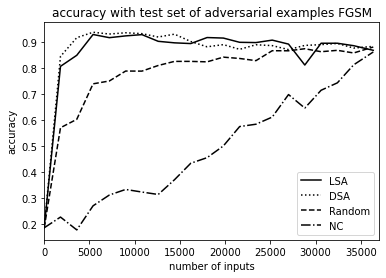

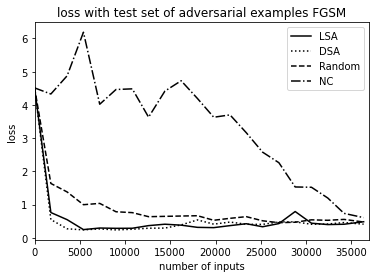

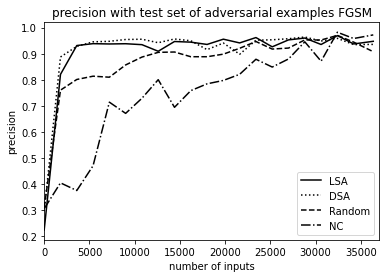

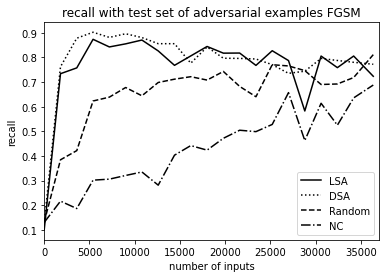

In [69]:
#configuration 2

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

#metric = "accuracy" # accuracy loss
my_metrics =["accuracy","loss","precision","recall"]

for metric in my_metrics:
    plt.clf()
    plt.plot(n_inputs,df_evaluate_lsa_0[metric],colors[0],linestyle=linestyles[0])
    plt.plot(n_inputs,df_evaluate_dsa_0[metric],colors[1],linestyle=linestyles[1])
    plt.plot(n_inputs,df_evaluate_random_0[metric],colors[2],linestyle=linestyles[2])
    plt.plot(n_inputs,df_evaluate_nc_0[metric],colors[3],linestyle=linestyles[3])


    legend_elements = [Line2D([0], [0], color='k', label='LSA',ls = linestyles[0]),
                   Line2D([0], [0], color='k', label='DSA',ls = linestyles[1]),
                   Line2D([0], [0], color='k', label='Random',ls = linestyles[2]),
                   Line2D([0], [0], color='k', label='NC',ls = linestyles[3])]



    plt.legend(handles=legend_elements)#

    plt.title(metric + " with test set of adversarial examples FGSM")
    plt.xlim([0, 37000])
    #plt.ylim([0, 1])
    plt.xlabel('number of inputs')
    plt.ylabel(metric)
    plt.savefig("gtsrb_c2_"+metric + "_0.svg")
    plt.show()

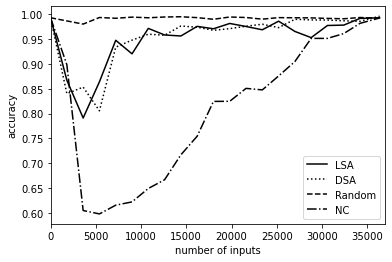

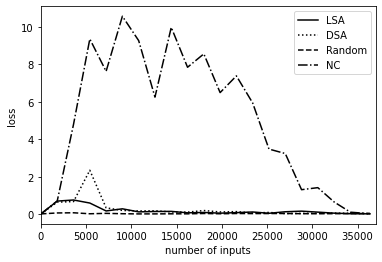

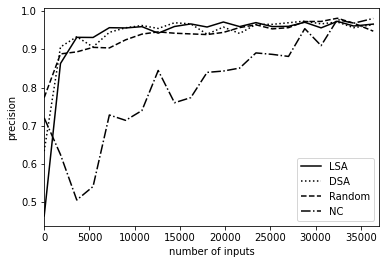

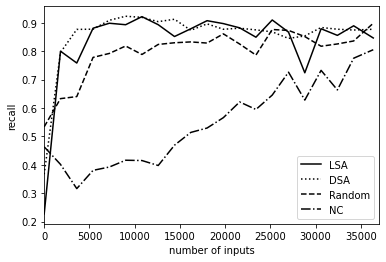

In [70]:
#configuration 2

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

my_metrics =["accuracy","loss","precision","recall"]

for metric in my_metrics:
    
#metric = "accuracy" # accuracy loss
    plt.clf()
    plt.plot(n_inputs,df_evaluate_lsa_1[metric],colors[0],linestyle=linestyles[0])
    plt.plot(n_inputs,df_evaluate_dsa_1[metric],colors[1],linestyle=linestyles[1])
    plt.plot(n_inputs,df_evaluate_random_1[metric],colors[2],linestyle=linestyles[2])
    plt.plot(n_inputs,df_evaluate_nc_1[metric],colors[3],linestyle=linestyles[3])

    legend_elements = [Line2D([0], [0], color='k', label='LSA',ls = linestyles[0]),
                   Line2D([0], [0], color='k', label='DSA',ls = linestyles[1]),
                   Line2D([0], [0], color='k', label='Random',ls = linestyles[2]),
                   Line2D([0], [0], color='k', label='NC',ls = linestyles[3])]



    plt.legend(handles=legend_elements)#
    plt.xlim([0, 37000])
    #plt.ylim([0, 1])
    plt.xlabel('number of inputs')
    plt.ylabel(metric)
    plt.savefig("gtsrb_c2_"+metric + "_1.svg")
    plt.show()

10800 0.9496558904647827
14400 0.9529696404933929
36366 0.9361457824707031
36366 0.9267142415046692


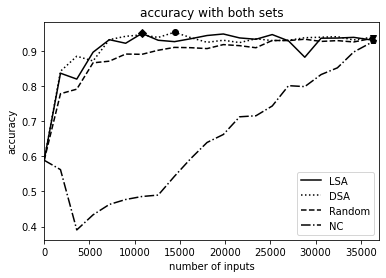

In [67]:

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches



plt.plot(n_inputs,accuracy_lsa_3,colors[0],linestyle=linestyles[0])
plt.plot(n_inputs,accuracy_dsa_3,colors[1],linestyle=linestyles[1])
plt.plot(n_inputs,accuracy_random_3,colors[2],linestyle=linestyles[2])
plt.plot(n_inputs,accuracy_nc_3,colors[3],linestyle=linestyles[3])


legend_elements = [Line2D([0], [0], color='k', label='LSA',ls = linestyles[0]),
                   Line2D([0], [0], color='k', label='DSA',ls = linestyles[1]),
                   Line2D([0], [0], color='k', label='Random',ls = linestyles[2]),
                   Line2D([0], [0], color='k', label='NC',ls = linestyles[3])]



plt.legend(handles=legend_elements)#
plt.title("accuracy with both sets")

print(n_inputs[np.argmax(accuracy_lsa_3)],accuracy_lsa_3.max())
print(n_inputs[np.argmax(accuracy_dsa_3)],accuracy_dsa_3.max())
print(n_inputs[np.argmax(accuracy_random_3)],accuracy_random_3.max())
print(n_inputs[np.argmax(accuracy_nc_3)],accuracy_nc_3.max())

plt.plot(n_inputs[np.argmax(accuracy_lsa_3)],accuracy_lsa_3.max(),'-kD')
plt.plot(n_inputs[np.argmax(accuracy_dsa_3)],accuracy_dsa_3.max(),'-ko')
plt.plot(n_inputs[np.argmax(accuracy_random_3)],accuracy_random_3.max(),'-kv')
plt.plot(n_inputs[np.argmax(accuracy_nc_3)],accuracy_nc_3.max(),'-kp')

plt.xlabel('number of inputs')
plt.ylabel('accuracy')
plt.xlim([0, 37000])
#plt.ylim([0, 1])

plt.savefig("gtsrb_c2_"+"accuracy" + "_both.svg")

plt.show()

In [49]:
n_inputs[3]

5400

In [53]:
print(n_inputs[3],accuracy_c3_lsa_3[3])
print(n_inputs[3],accuracy_c3_dsa_3[3])
print(n_inputs[3],accuracy_c3_nc_3[3])
print(n_inputs[3],accuracy_c3_random_3[3])




5400 0.8961254060268402
5400 0.8712719976902008
5400 0.4333418160676956
5400 0.8659189641475677


In [37]:
print(accuracy_c3_lsa_5k_3)
print(accuracy_c3_dsa_5k_3)
print(accuracy_c3_random_5k_3)
print(accuracy_c3_nc_5k_3)




[0.83889881]
[0.8770074]
[0.64211065]
[0.61445323]


## Saving models

In [63]:
model_lsa_dir_5000  = "D:/models/gtsrb/C3/gtsrb_model_c3_sep_lsa_e2_5000"

model_lsa_5000.save(model_lsa_dir_5000)

INFO:tensorflow:Assets written to: D:/models/gtsrb/C3/gtsrb_model_c3_sep_lsa_e2_5000\assets
Model has been saved


In [25]:
model_dsa_dir_5000  = "D:/models/gtsrb/C3/gtsrb_model_c3_sep_dsa_e2_5000"

model_dsa_5000.save(model_dsa_dir_5000)

INFO:tensorflow:Assets written to: D:/models/gtsrb/C3/gtsrb_model_c3_sep_dsa_e2_5000\assets
Model has been saved


In [26]:
model_random_dir_5000  = "D:/models/gtsrb/C3/gtsrb_model_c3_sep_random_e2_5000"

model_random_5000.save(model_random_dir_5000)

INFO:tensorflow:Assets written to: D:/models/gtsrb/C3/gtsrb_model_c3_sep_random_e2_5000\assets
Model has been saved


In [27]:
model_nc_dir_5000  = "D:/models/gtsrb/C3/gtsrb_model_c3_sep_nc_e2_5000"

model_nc_5000.save(model_nc_dir_5000)

INFO:tensorflow:Assets written to: D:/models/gtsrb/C3/gtsrb_model_c3_sep_nc_e2_5000\assets
Model has been saved


In [15]:
new_model_lsa_dir  = "D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_lsa_e2"
i=0

for model in models_lsa:
    model.save(new_model_lsa_dir+"_"+str(i))
    i+=1

INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_lsa_e2_0\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_lsa_e2_1\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_lsa_e2_2\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_lsa_e2_3\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_lsa_e2_4\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_lsa_e2_5\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_lsa_e2_6\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_lsa_e2_7\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gts

In [18]:
new_model_dsa_dir  = "D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_dsa_e2"

i=0
for model in models_dsa:
    model.save(new_model_dsa_dir+"_"+str(i))
    i+=1

INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_dsa_e2_0\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_dsa_e2_1\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_dsa_e2_2\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_dsa_e2_3\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_dsa_e2_4\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_dsa_e2_5\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_dsa_e2_6\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_dsa_e2_7\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gts

In [20]:
new_model_random_dir  = "D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_random_e2"

i=0
for model in models_random:
    model.save(new_model_random_dir+"_"+str(i))
    i+=1

INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_random_e2_0\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_random_e2_1\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_random_e2_2\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_random_e2_3\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_random_e2_4\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_random_e2_5\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_random_e2_6\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_random_e2_7\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/mo

In [22]:
model_nc_dir  = "D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_nc_e2"

i=0
for model in models_nc:
    model.save(model_nc_dir+"_"+str(i))
    i+=1

INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_nc_e2_0\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_nc_e2_1\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_nc_e2_2\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_nc_e2_3\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_nc_e2_4\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_nc_e2_5\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_nc_e2_6\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gtsrb_model_c2_sep_nc_e2_7\assets
Model has been saved
INFO:tensorflow:Assets written to: D:/models/gtsrb_models/C2/gtsrb_model